In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.preprocessing import MinMaxScaler
import joblib
from lib.loader import FolderExtractor, SingleFileExtractor

# === PARAMETRY ===
HDF_PATH = "data"
SIGNAL_NAME = "art"
WINDOW_SIZE = 1000
N_COMPONENTS = WINDOW_SIZE // 2 + 1
LATENT_DIM = 48
EPOCHS = 100
BATCH_SIZE = 32
MAX_BETA = 1e-2
MIN_KL = 0.2
MODEL_DIR = "models2"
SCALER_PATH = os.path.join(MODEL_DIR, "rfft_scaler.pkl")
os.makedirs(MODEL_DIR, exist_ok=True)

# === NAČTENÍ A FFT ===
def get_file_paths(folder_path):
    return [e._hdf5_file_path for e in FolderExtractor(folder_path)._extractors]

def load_signal(file_path, annotations_path, signal_name="art"):
    extractor = SingleFileExtractor(file_path)
    extractor.auto_annotate(annotations_path)
    segments, _ = extractor.extract(signal_name)
    extractor.load_data(segments)
    clean = [s.data for s in segments if not s.anomalous and s.data is not None]
    return np.concatenate(clean) if clean else np.array([])

def compute_rfft_spectra(signal, window_size):
    spectra, originals = [], []
    for i in range(0, len(signal) - window_size + 1, window_size):
        window = signal[i:i + window_size]
        if not np.isnan(window).any():
            fft_vals = np.fft.rfft(window)
            spectrum = np.stack([fft_vals.real, fft_vals.imag], axis=-1)
            spectra.append(spectrum)
            originals.append(window)
    return np.array(spectra), np.array(originals)

# === PŘÍPRAVA DAT ===
spectra_list, originals_list = [], []
for path in get_file_paths(HDF_PATH):
    signal = load_signal(path, HDF_PATH, SIGNAL_NAME)
    if signal.size == 0:
        continue
    spec, orig = compute_rfft_spectra(signal, WINDOW_SIZE)
    spectra_list.append(spec)
    originals_list.append(orig)

X = np.vstack(spectra_list)
originals = np.vstack(originals_list)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X.reshape(-1, 2)).reshape(X.shape)
joblib.dump(scaler, SCALER_PATH)

# === SAMPLING ===
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# === ENCODER ===
def build_encoder(input_shape, latent_dim):
    inputs = layers.Input(shape=input_shape)
    x = layers.Flatten()(inputs)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dense(128, activation="relu")(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)
    z = Sampling()([z_mean, z_log_var])
    return Model(inputs, [z_mean, z_log_var, z], name="encoder")

# === DECODER ===
def build_decoder(latent_dim, output_shape):
    inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(256)(inputs)
    x = layers.LayerNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(512)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dense(np.prod(output_shape))(x)
    x = layers.Activation("tanh")(x)
    outputs = layers.Reshape(output_shape)(x)
    return Model(inputs, outputs, name="decoder")

# === VAE S ANNEALING A FREE BITS ===
class VAE(Model):
    def __init__(self, encoder, decoder, total_epochs, max_beta=1e-2, min_kl=0.2):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.total_epochs = total_epochs
        self.max_beta = max_beta
        self.min_kl = min_kl
        self.current_epoch = tf.Variable(0, trainable=False, dtype=tf.float32)

        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer

    def train_step(self, data):
        if isinstance(data, tuple): data = data[0]

        progress = self.current_epoch / self.total_epochs
        beta = self.max_beta * tf.sigmoid((progress - 0.5) * 10.0)

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            recon = self.decoder(z)

            loss_recon = tf.reduce_mean(tf.square(data - recon))
            kl_per_dim = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_sum = tf.reduce_mean(tf.reduce_sum(tf.maximum(kl_per_dim, self.min_kl), axis=1))
            loss_total = loss_recon + beta * kl_sum

        grads = tape.gradient(loss_total, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(loss_total)
        self.recon_loss_tracker.update_state(loss_recon)
        self.kl_loss_tracker.update_state(kl_sum)
        self.current_epoch.assign_add(1.0 / tf.cast(self.total_epochs, tf.float32))

        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result()
        }

# === CALLBACK: UKLÁDÁNÍ KAŽDÝCH 10 EPOCH ===
class SaveEveryNEpoch(tf.keras.callbacks.Callback):
    def __init__(self, n, model_dir, encoder, decoder):
        super().__init__()
        self.n = n
        self.model_dir = model_dir
        self.encoder = encoder
        self.decoder = decoder

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.n == 0:
            enc_path = os.path.join(self.model_dir, f"vae_encoder_epoch{epoch+1:03d}.keras")
            dec_path = os.path.join(self.model_dir, f"vae_decoder_epoch{epoch+1:03d}.keras")
            self.encoder.save(enc_path)
            self.decoder.save(dec_path)
            print(f"✅ Model uložen: {enc_path}, {dec_path}")

# === TRÉNINK ===
encoder = build_encoder((N_COMPONENTS, 2), LATENT_DIM)
decoder = build_decoder(LATENT_DIM, (N_COMPONENTS, 2))
vae = VAE(encoder, decoder, total_epochs=EPOCHS, max_beta=MAX_BETA, min_kl=MIN_KL)
vae.compile(optimizer=tf.keras.optimizers.Adam(1e-4))
vae.fit(
    X_scaled,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[SaveEveryNEpoch(n=10, model_dir=MODEL_DIR, encoder=encoder, decoder=decoder)]
)

# === POSLEDNÍ ULOŽENÍ ===
encoder.save(os.path.join(MODEL_DIR, "vae_encoder_final.keras"))
decoder.save(os.path.join(MODEL_DIR, "vae_decoder_final.keras"))

# === REKONSTRUKCE ===
reconstructed = decoder(encoder(X_scaled)[2]).numpy()
reconstructed = scaler.inverse_transform(reconstructed.reshape(-1, 2)).reshape(reconstructed.shape)

for i in range(3):
    spectrum = reconstructed[i][:, 0] + 1j * reconstructed[i][:, 1]
    recon_time = np.fft.irfft(spectrum, n=WINDOW_SIZE)
    plt.figure(figsize=(10, 2))
    plt.plot(originals[i], label="Originál")
    plt.plot(recon_time, label="Rekonstrukce")
    plt.legend()
    plt.tight_layout()
    plt.show()

# === GENEROVÁNÍ ===
z_mean, _, _ = encoder.predict(X_scaled, batch_size=32)
noise = tf.random.normal(shape=z_mean[:3].shape, stddev=0.5)
random_latents = z_mean[:3] + noise

generated = decoder(random_latents).numpy()
generated = scaler.inverse_transform(generated.reshape(-1, 2)).reshape(generated.shape)

for i in range(3):
    spectrum = generated[i][:, 0] + 1j * generated[i][:, 1]
    gen_time = np.fft.irfft(spectrum, n=WINDOW_SIZE)
    plt.figure(figsize=(10, 2))
    plt.plot(gen_time)
    plt.title(f"Generovaný signál {i+1}")
    plt.tight_layout()
    plt.show()


In [ ]:
import os
import joblib
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras import layers
from tensorflow.keras.saving import register_keras_serializable

# === REGISTRACE Sampling vrstvy ===
@register_keras_serializable()
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# === PARAMETRY ===
MODEL_DIR = "models2"
SCALER_PATH = os.path.join(MODEL_DIR, "rfft_scaler.pkl")
WINDOW_SIZE = 1000
N_COMPONENTS = WINDOW_SIZE // 2 + 1
LATENT_DIM = 48

# === KONTROLA EXISTENCE DAT ===
if 'X_scaled' not in globals() or 'originals' not in globals():
    raise RuntimeError("❌ Proměnné 'X_scaled' a 'originals' nejsou načteny. Spusť tréninkový skript nebo načti data.")

# === NAČTI SCALER ===
scaler = joblib.load(SCALER_PATH)

# === MANUÁLNĚ DEFINOVANÉ MODELY ===
model_pairs = [
    ("models2/vae_encoder_epoch010.keras", "models2/vae_decoder_epoch010.keras", 10),
    ("models2/vae_encoder_epoch020.keras", "models2/vae_decoder_epoch020.keras", 20),
    ("models2/vae_encoder_epoch030.keras", "models2/vae_decoder_epoch030.keras", 30),
    ("models2/vae_encoder_epoch040.keras", "models2/vae_decoder_epoch040.keras", 40),
    ("models2/vae_encoder_epoch050.keras", "models2/vae_decoder_epoch050.keras", 50),
    ("models2/vae_encoder_epoch060.keras", "models2/vae_decoder_epoch060.keras", 60),
    ("models2/vae_encoder_epoch070.keras", "models2/vae_decoder_epoch070.keras", 70),
    ("models2/vae_encoder_epoch080.keras", "models2/vae_decoder_epoch080.keras", 80),
    ("models2/vae_encoder_epoch090.keras", "models2/vae_decoder_epoch090.keras", 90),
    ("models2/vae_encoder_epoch100.keras", "models2/vae_decoder_epoch100.keras", 100),
]

# === PROCESUJ KAŽDOU EPOCHU ===
for encoder_path, decoder_path, epoch in model_pairs:
    print(f"\n🔍 Epoch {epoch}")

    encoder = load_model(encoder_path, compile=False, custom_objects={"Sampling": Sampling})
    decoder = load_model(decoder_path, compile=False)

    # === PRVNÍ VZOREK ===
    sample = X_scaled[0:1]
    original = originals[0]

    # === REKONSTRUKCE ===
    z = encoder.predict(sample)[2]
    recon = decoder.predict(z)
    recon = scaler.inverse_transform(recon.reshape(-1, 2)).reshape(recon.shape)[0]
    recon_spectrum = recon[:, 0] + 1j * recon[:, 1]
    recon_time = np.fft.irfft(recon_spectrum, n=WINDOW_SIZE)

    # === GENERACE ===
    z_gen = z + np.random.normal(size=z.shape)
    gen = decoder.predict(z_gen)
    gen = scaler.inverse_transform(gen.reshape(-1, 2)).reshape(gen.shape)[0]
    gen_spectrum = gen[:, 0] + 1j * gen[:, 1]
    gen_time = np.fft.irfft(gen_spectrum, n=WINDOW_SIZE)

    # === VYKRESLENÍ ===
    plt.figure(figsize=(12, 3))
    plt.plot(original, label="Originál", linewidth=1)
    plt.plot(recon_time, label="Rekonstrukce", linestyle="--")
    plt.plot(gen_time, label="Generace", linestyle=":")
    plt.title(f"Epoch {epoch} – Jeden vzorek")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.preprocessing import StandardScaler
import joblib
from lib.loader import FolderExtractor, SingleFileExtractor
from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras.models import load_model

# === PARAMETRY ===
HDF_PATH = "data"
SIGNAL_NAME = "art"
WINDOW_SIZE = 1000
N_COMPONENTS = WINDOW_SIZE // 2 + 1
LATENT_DIM = 48
EPOCHS = 30
BATCH_SIZE = 32
MAX_BETA = 1e-2
MIN_KL = 0.2
MODEL_DIR = "models2"
SCALER_PATH = os.path.join(MODEL_DIR, "rfft_scaler.pkl")
os.makedirs(MODEL_DIR, exist_ok=True)

# === NAHRANI A FFT ===
def get_file_paths(folder_path):
    return [e._hdf5_file_path for e in FolderExtractor(folder_path)._extractors]

def load_signal(file_path, annotations_path, signal_name="art"):
    extractor = SingleFileExtractor(file_path)
    extractor.auto_annotate(annotations_path)
    segments, _ = extractor.extract(signal_name)
    extractor.load_data(segments)
    clean = [s.data for s in segments if not s.anomalous and s.data is not None]
    return np.concatenate(clean) if clean else np.array([])

def compute_rfft_spectra(signal, window_size):
    spectra, originals = [], []
    for i in range(0, len(signal) - window_size + 1, window_size):
        window = signal[i:i + window_size]
        if not np.isnan(window).any():
            fft_vals = np.fft.rfft(window)
            spectrum = np.stack([fft_vals.real, fft_vals.imag], axis=-1)
            spectra.append(spectrum)
            originals.append(window)
    return np.array(spectra), np.array(originals)

# === PŘÍPRAVA DAT ===
spectra_list, originals_list = [], []
for path in get_file_paths(HDF_PATH):
    signal = load_signal(path, HDF_PATH, SIGNAL_NAME)
    if signal.size == 0:
        continue
    spec, orig = compute_rfft_spectra(signal, WINDOW_SIZE)
    spectra_list.append(spec)
    originals_list.append(orig)

X = np.vstack(spectra_list)
originals = np.vstack(originals_list)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.reshape(-1, 2)).reshape(X.shape)
joblib.dump(scaler, SCALER_PATH)

# === SAMPLING ===
@register_keras_serializable()
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# === ENCODER ===
def build_encoder(input_shape, latent_dim):
    inputs = layers.Input(shape=input_shape)
    x = layers.Flatten()(inputs)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dense(128, activation="relu")(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)
    z = Sampling()([z_mean, z_log_var])
    return Model(inputs, [z_mean, z_log_var, z], name="encoder")

# === DECODER ===
def build_decoder(latent_dim, output_shape):
    inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(256, activation="relu")(inputs)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dense(np.prod(output_shape))(x)
    outputs = layers.Reshape(output_shape)(x)
    return Model(inputs, outputs, name="decoder")

# === VAE ===
class VAE(Model):
    def __init__(self, encoder, decoder, total_epochs, max_beta=1e-2, min_kl=0.2):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.total_epochs = total_epochs
        self.max_beta = max_beta
        self.min_kl = min_kl
        self.current_epoch = tf.Variable(0, trainable=False, dtype=tf.float32)

        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer

    def train_step(self, data):
        if isinstance(data, tuple): data = data[0]

        progress = self.current_epoch / self.total_epochs
        beta = self.max_beta * tf.sigmoid((progress - 0.5) * 10.0)

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            recon = self.decoder(z)

            loss_recon = tf.reduce_mean(tf.square(data - recon))
            kl_per_dim = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_sum = tf.reduce_mean(tf.reduce_sum(tf.maximum(kl_per_dim, self.min_kl), axis=1))
            loss_total = loss_recon + beta * kl_sum

        grads = tape.gradient(loss_total, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(loss_total)
        self.recon_loss_tracker.update_state(loss_recon)
        self.kl_loss_tracker.update_state(kl_sum)
        self.current_epoch.assign_add(1.0 / tf.cast(self.total_epochs, tf.float32))

        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result()
        }

# === TRÉNINK A PRŮBĚŽNÉ UKLÁDÁNÍ MODELŮ ===
encoder = build_encoder((N_COMPONENTS, 2), LATENT_DIM)
decoder = build_decoder(LATENT_DIM, (N_COMPONENTS, 2))
vae = VAE(encoder, decoder, total_epochs=EPOCHS, max_beta=MAX_BETA, min_kl=MIN_KL)
vae.compile(optimizer=tf.keras.optimizers.Adam(1e-4))

for epoch in range(1, EPOCHS + 1):
    vae.fit(X_scaled, epochs=1, batch_size=BATCH_SIZE, verbose=0)
    if epoch % 10 == 0 or epoch == EPOCHS:
        encoder.save(os.path.join(MODEL_DIR, f"vae_encoder_epoch{epoch:03d}.keras"))
        decoder.save(os.path.join(MODEL_DIR, f"vae_decoder_epoch{epoch:03d}.keras"))

# === ULOZENI POSLEDNIHO MODELU ===
encoder.save(os.path.join(MODEL_DIR, "vae_encoder_final.keras"))
decoder.save(os.path.join(MODEL_DIR, "vae_decoder_final.keras"))

# === TESTUJ VSECHNY MODELY V MODELS2 ===
model_files = sorted(os.listdir(MODEL_DIR))
encoders = [f for f in model_files if f.startswith("vae_encoder_epoch")]
decoders = [f for f in model_files if f.startswith("vae_decoder_epoch")]

model_pairs = []
for enc_file in encoders:
    epoch = enc_file.replace("vae_encoder_epoch", "").replace(".keras", "")
    dec_file = f"vae_decoder_epoch{epoch}.keras"
    if dec_file in decoders:
        model_pairs.append((
            os.path.join(MODEL_DIR, enc_file),
            os.path.join(MODEL_DIR, dec_file),
            int(epoch)
        ))

sample = X_scaled[0:1]
original = originals[0]

for encoder_path, decoder_path, epoch in model_pairs:
    print(f"\n🔍 Epoch {epoch}")
    encoder = load_model(encoder_path, compile=False, custom_objects={"Sampling": Sampling})
    decoder = load_model(decoder_path, compile=False)

    # === REKONSTRUKCE ===
    z = encoder.predict(sample)[2]
    recon = decoder.predict(z)
    recon = scaler.inverse_transform(recon.reshape(-1, 2)).reshape(recon.shape)[0]
    recon_spectrum = recon[:, 0] + 1j * recon[:, 1]
    recon_time = np.fft.irfft(recon_spectrum, n=WINDOW_SIZE)

    # === GENERACE ===
    z_gen = z + np.random.normal(size=z.shape)
    gen = decoder.predict(z_gen)
    gen = scaler.inverse_transform(gen.reshape(-1, 2)).reshape(gen.shape)[0]
    gen_spectrum = gen[:, 0] + 1j * gen[:, 1]
    gen_time = np.fft.irfft(gen_spectrum, n=WINDOW_SIZE)

    # === GRAF ===
    plt.figure(figsize=(12, 3))
    plt.plot(original, label="Originál", linewidth=1)
    plt.plot(recon_time, label="Rekonstrukce", linestyle="--")
    plt.plot(gen_time, label="Generace", linestyle=":")
    plt.title(f"Epoch {epoch} – Jeden vzorek")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.preprocessing import StandardScaler
import joblib
from lib.loader import FolderExtractor, SingleFileExtractor
from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras.models import load_model

# === PARAMETRY ===
HDF_PATH = "data"
SIGNAL_NAME = "art"
WINDOW_SIZE = 1000
N_COMPONENTS = WINDOW_SIZE // 2 + 1
LATENT_DIM = 48
EPOCHS = 100
BATCH_SIZE = 32
MAX_BETA = 1e-2
MIN_KL = 0.2
MODEL_DIR = "modelsHyper"
SCALER_PATH = os.path.join(MODEL_DIR, "rfft_scaler.pkl")
os.makedirs(MODEL_DIR, exist_ok=True)

# === NAHRANI A FFT ===
def get_file_paths(folder_path):
    return [e._hdf5_file_path for e in FolderExtractor(folder_path)._extractors]

def load_signal(file_path, annotations_path, signal_name="art"):
    extractor = SingleFileExtractor(file_path)
    extractor.auto_annotate(annotations_path)
    segments, _ = extractor.extract(signal_name)
    extractor.load_data(segments)
    clean = [s.data for s in segments if not s.anomalous and s.data is not None]
    return np.concatenate(clean) if clean else np.array([])

def compute_rfft_spectra(signal, window_size):
    spectra, originals = [], []
    for i in range(0, len(signal) - window_size + 1, window_size):
        window = signal[i:i + window_size]
        if not np.isnan(window).any():
            fft_vals = np.fft.rfft(window)
            spectrum = np.stack([fft_vals.real, fft_vals.imag], axis=-1)
            spectra.append(spectrum)
            originals.append(window)
    return np.array(spectra), np.array(originals)

# === PŘÍPRAVA DAT ===
spectra_list, originals_list = [], []
for path in get_file_paths(HDF_PATH):
    signal = load_signal(path, HDF_PATH, SIGNAL_NAME)
    if signal.size == 0:
        continue
    spec, orig = compute_rfft_spectra(signal, WINDOW_SIZE)
    spectra_list.append(spec)
    originals_list.append(orig)

X = np.vstack(spectra_list)
originals = np.vstack(originals_list)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.reshape(-1, 2)).reshape(X.shape)
joblib.dump(scaler, SCALER_PATH)

# === SAMPLING ===
@register_keras_serializable()
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# === ENCODER ===
def build_encoder(input_shape, latent_dim):
    inputs = layers.Input(shape=input_shape)
    x = layers.Flatten()(inputs)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dense(32, activation="relu")(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)
    z = Sampling()([z_mean, z_log_var])
    return Model(inputs, [z_mean, z_log_var, z], name="encoder")

# === DECODER ===
def build_decoder(latent_dim, output_shape):
    inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(64, activation="relu")(inputs)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dense(np.prod(output_shape))(x)
    outputs = layers.Reshape(output_shape)(x)
    return Model(inputs, outputs, name="decoder")

# === VAE ===
class VAE(Model):
    def __init__(self, encoder, decoder, total_epochs, max_beta=1e-2, min_kl=0.2):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.total_epochs = total_epochs
        self.max_beta = max_beta
        self.min_kl = min_kl
        self.current_epoch = tf.Variable(0, trainable=False, dtype=tf.float32)

        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer

    def train_step(self, data):
        if isinstance(data, tuple): data = data[0]

        progress = self.current_epoch / self.total_epochs
        beta = self.max_beta * tf.sigmoid((progress - 0.5) * 10.0)

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            recon = self.decoder(z)

            loss_recon = tf.reduce_mean(tf.square(data - recon))
            kl_per_dim = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_sum = tf.reduce_mean(tf.reduce_sum(tf.maximum(kl_per_dim, self.min_kl), axis=1))
            loss_total = loss_recon + beta * kl_sum

        grads = tape.gradient(loss_total, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(loss_total)
        self.recon_loss_tracker.update_state(loss_recon)
        self.kl_loss_tracker.update_state(kl_sum)
        self.current_epoch.assign_add(1.0 / tf.cast(self.total_epochs, tf.float32))

        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result()
        }

# === TRÉNINK A PRŮBĚŽNÉ UKLÁDÁNÍ MODELŮ ===
encoder = build_encoder((N_COMPONENTS, 2), LATENT_DIM)
decoder = build_decoder(LATENT_DIM, (N_COMPONENTS, 2))
vae = VAE(encoder, decoder, total_epochs=EPOCHS, max_beta=MAX_BETA, min_kl=MIN_KL)
vae.compile(optimizer=tf.keras.optimizers.Adam(1e-4))

for epoch in range(1, EPOCHS + 1):
    print(f"epocha: {epoch}")
    vae.fit(X_scaled, epochs=1, batch_size=BATCH_SIZE, verbose=0)
    if epoch % 10 == 0 or epoch == EPOCHS:
        encoder.save(os.path.join(MODEL_DIR, f"vae_encoder_epoch{epoch:03d}.keras"))
        decoder.save(os.path.join(MODEL_DIR, f"vae_decoder_epoch{epoch:03d}.keras"))

# === ULOZENI POSLEDNIHO MODELU ===
encoder.save(os.path.join(MODEL_DIR, "vae_encoder_final.keras"))
decoder.save(os.path.join(MODEL_DIR, "vae_decoder_final.keras"))

# === TESTUJ VSECHNY MODELY V MODELS2 ===
model_files = sorted(os.listdir(MODEL_DIR))
encoders = [f for f in model_files if f.startswith("vae_encoder_epoch")]
decoders = [f for f in model_files if f.startswith("vae_decoder_epoch")]

model_pairs = []
for enc_file in encoders:
    epoch = enc_file.replace("vae_encoder_epoch", "").replace(".keras", "")
    dec_file = f"vae_decoder_epoch{epoch}.keras"
    if dec_file in decoders:
        model_pairs.append((
            os.path.join(MODEL_DIR, enc_file),
            os.path.join(MODEL_DIR, dec_file),
            int(epoch)
        ))

sample = X_scaled[0:1]
original = originals[0]

for encoder_path, decoder_path, epoch in model_pairs:
    print(f"\n🔍 Epoch {epoch}")
    encoder = load_model(encoder_path, compile=False, custom_objects={"Sampling": Sampling})
    decoder = load_model(decoder_path, compile=False)

    # === REKONSTRUKCE ===
    z = encoder.predict(sample)[2]
    recon = decoder.predict(z)
    recon = scaler.inverse_transform(recon.reshape(-1, 2)).reshape(recon.shape)[0]
    recon_spectrum = recon[:, 0] + 1j * recon[:, 1]
    recon_time = np.fft.irfft(recon_spectrum, n=WINDOW_SIZE)

    # === GENERACE ===
    z_gen = z + np.random.normal(size=z.shape)
    gen = decoder.predict(z_gen)
    gen = scaler.inverse_transform(gen.reshape(-1, 2)).reshape(gen.shape)[0]
    gen_spectrum = gen[:, 0] + 1j * gen[:, 1]
    gen_time = np.fft.irfft(gen_spectrum, n=WINDOW_SIZE)

    # === GRAF ===
    plt.figure(figsize=(12, 3))
    plt.plot(original, label="Originál", linewidth=1)
    plt.plot(recon_time, label="Rekonstrukce", linestyle="--")
    plt.plot(gen_time, label="Generace", linestyle=":")
    plt.title(f"Epoch {epoch} – Jeden vzorek")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
...

for idx, (encoder_path, decoder_path, epoch) in enumerate(model_pairs):
    print(f"\n🔍 Epoch {epoch}")
    encoder = load_model(encoder_path, compile=False, custom_objects={"Sampling": Sampling})
    decoder = load_model(decoder_path, compile=False)

    # === VSTUPNÍ VZOREK ===
    sample = X_scaled[idx % len(X_scaled)][None, ...]  # jiný vzorek pro každou epochu
    original = originals[idx % len(originals)]

    # === REKONSTRUKCE ===
    z_mean, z_log_var, z = encoder.predict(sample)
    recon = decoder.predict(z)
    recon = scaler.inverse_transform(recon.reshape(-1, 2)).reshape(recon.shape)[0]
    recon_spectrum = recon[:, 0] + 1j * recon[:, 1]
    recon_time = np.fft.irfft(recon_spectrum, n=WINDOW_SIZE)

    # === GENERACE (nový náhodný vzorek) ===
    z_new = np.random.normal(size=z.shape)
    gen = decoder.predict(z_new)
    gen = scaler.inverse_transform(gen.reshape(-1, 2)).reshape(gen.shape)[0]
    gen_spectrum = gen[:, 0] + 1j * gen[:, 1]
    gen_time = np.fft.irfft(gen_spectrum, n=WINDOW_SIZE)

    # === GRAF V SUBPLOTECH ===
    fig, axs = plt.subplots(1, 3, figsize=(15, 3), sharey=True)
    axs[0].plot(original)
    axs[0].set_title("Originál")

    axs[1].plot(recon_time)
    axs[1].set_title("Rekonstrukce")

    axs[2].plot(gen_time)
    axs[2].set_title("Generace (nový z)")

    fig.suptitle(f"Epoch {epoch} – srovnání vstup/recon/generace")
    plt.tight_layout()
    plt.show()


Epocha: 1
Epocha: 2
Epocha: 3
Epocha: 4
Epocha: 5
Epocha: 6
Epocha: 7
Epocha: 8
Epocha: 9
Epocha: 10
Epocha: 11
Epocha: 12
Epocha: 13
Epocha: 14
Epocha: 15
Epocha: 16
Epocha: 17
Epocha: 18
Epocha: 19
Epocha: 20
Epocha: 21
Epocha: 22
Epocha: 23
Epocha: 24
Epocha: 25
Epocha: 26
Epocha: 27
Epocha: 28
Epocha: 29
Epocha: 30
Epocha: 31
Epocha: 32
Epocha: 33
Epocha: 34
Epocha: 35
Epocha: 36
Epocha: 37
Epocha: 38
Epocha: 39
Epocha: 40
Epocha: 41
Epocha: 42
Epocha: 43
Epocha: 44
Epocha: 45
Epocha: 46
Epocha: 47
Epocha: 48
Epocha: 49
Epocha: 50
Epocha: 51
Epocha: 52
Epocha: 53
Epocha: 54
Epocha: 55
Epocha: 56
Epocha: 57
Epocha: 58
Epocha: 59
Epocha: 60
Epocha: 61
Epocha: 62
Epocha: 63
Epocha: 64
Epocha: 65
Epocha: 66
Epocha: 67
Epocha: 68
Epocha: 69
Epocha: 70
Epocha: 71
Epocha: 72
Epocha: 73
Epocha: 74
Epocha: 75
Epocha: 76
Epocha: 77
Epocha: 78
Epocha: 79
Epocha: 80
Epocha: 81
Epocha: 82
Epocha: 83
Epocha: 84
Epocha: 85
Epocha: 86
Epocha: 87
Epocha: 88
Epocha: 89
Epocha: 90
Epocha: 91
Epocha: 

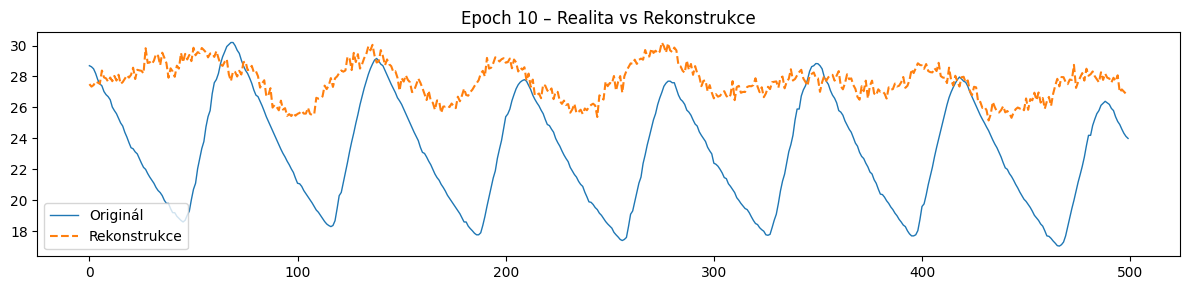

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


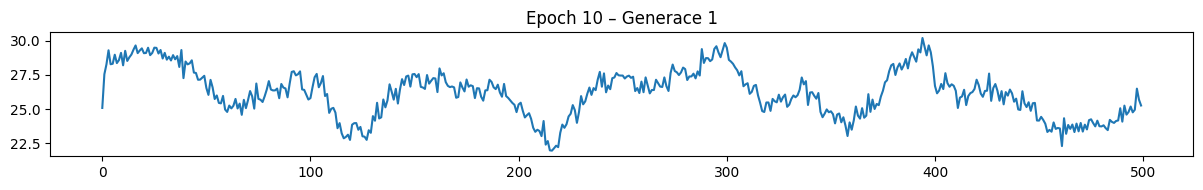

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


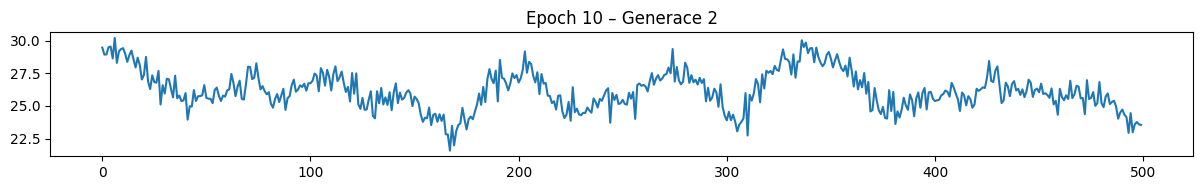

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


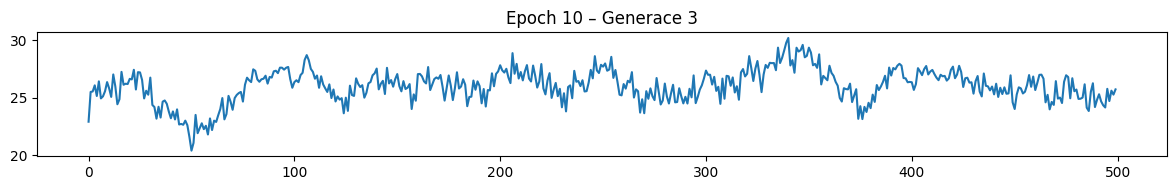


🔍 Epoch 20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


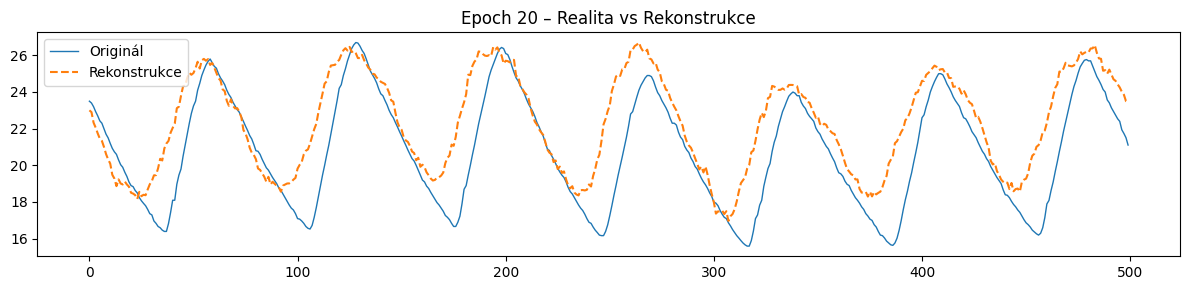

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


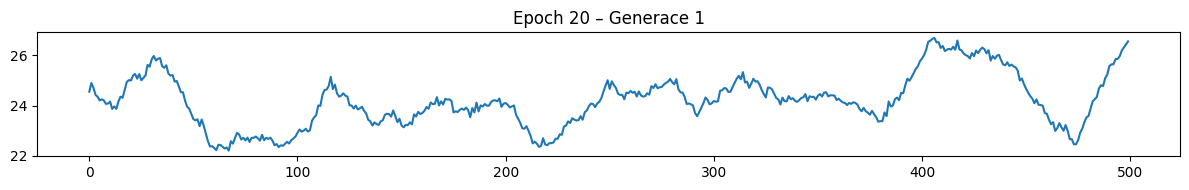

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


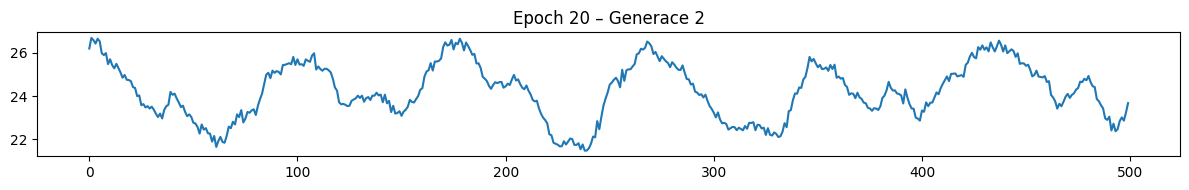

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


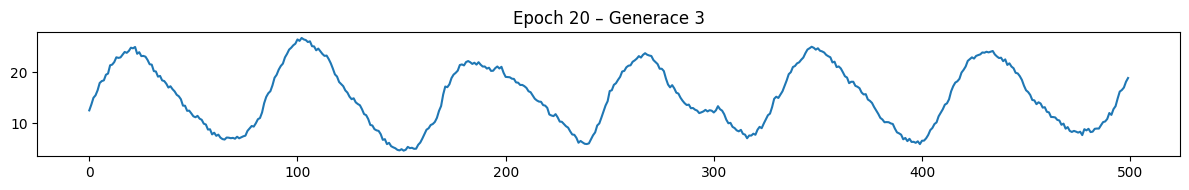


🔍 Epoch 30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


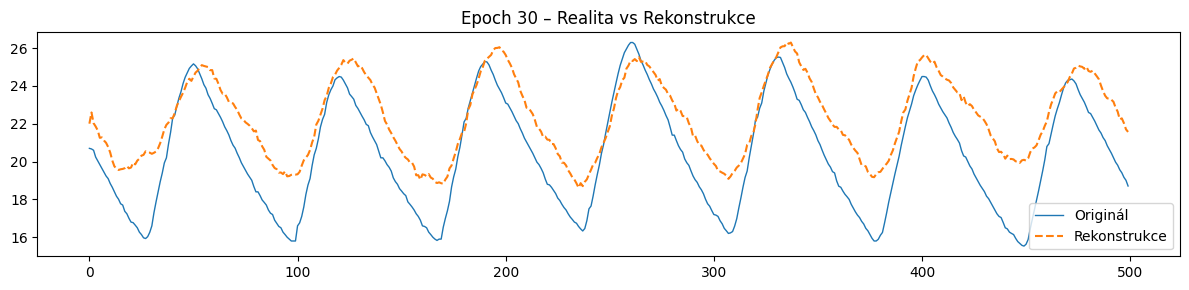

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


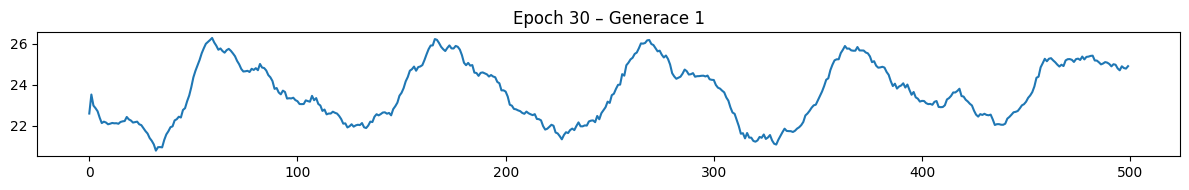

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


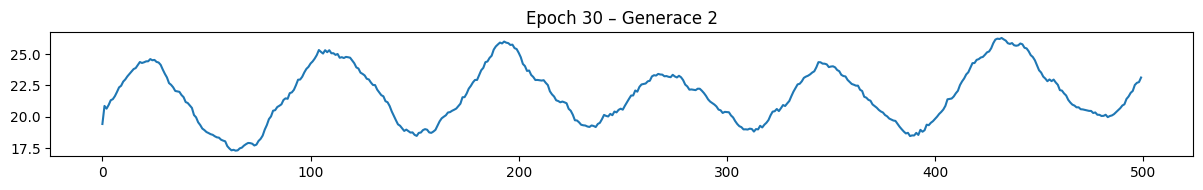

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


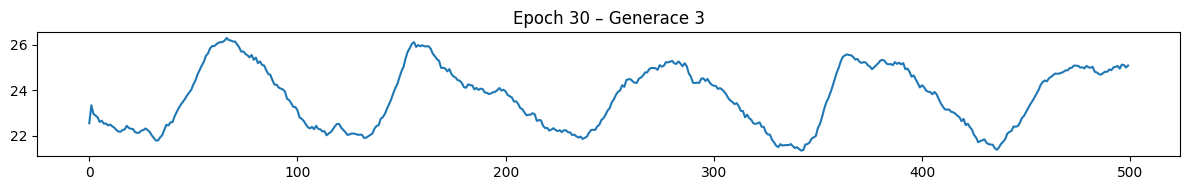


🔍 Epoch 40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


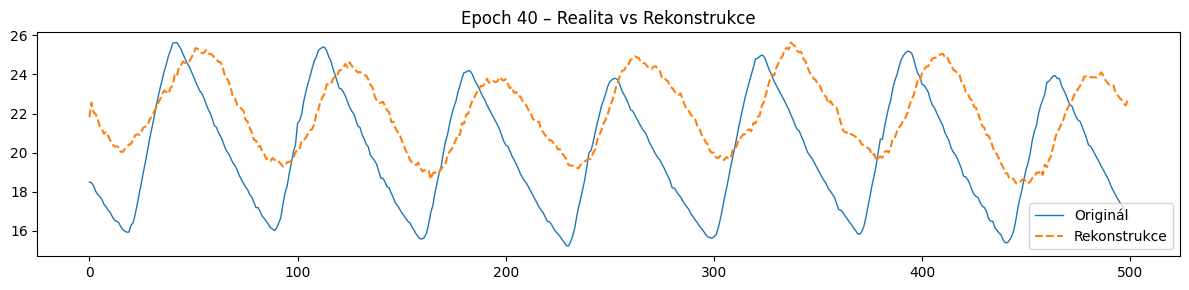

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


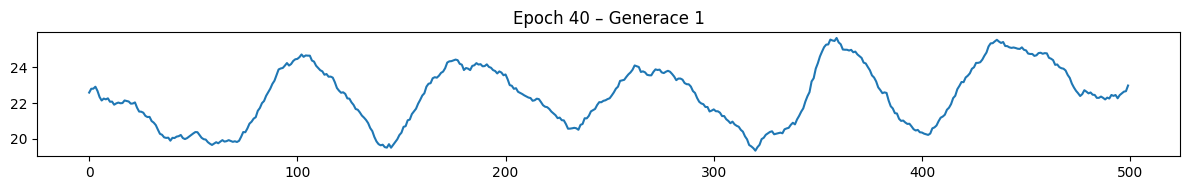

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


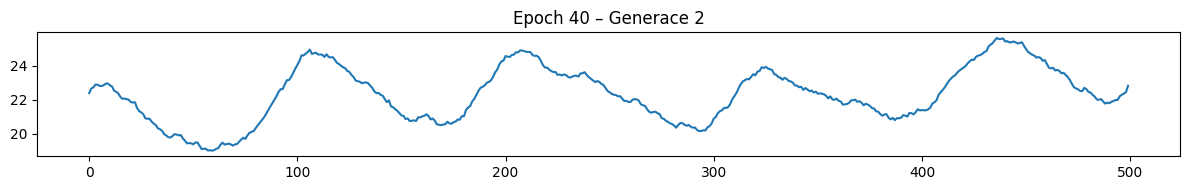

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


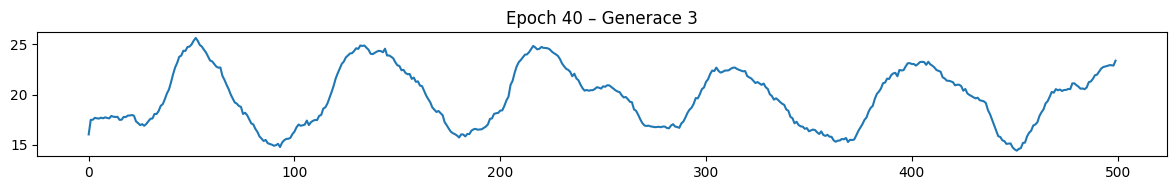


🔍 Epoch 50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


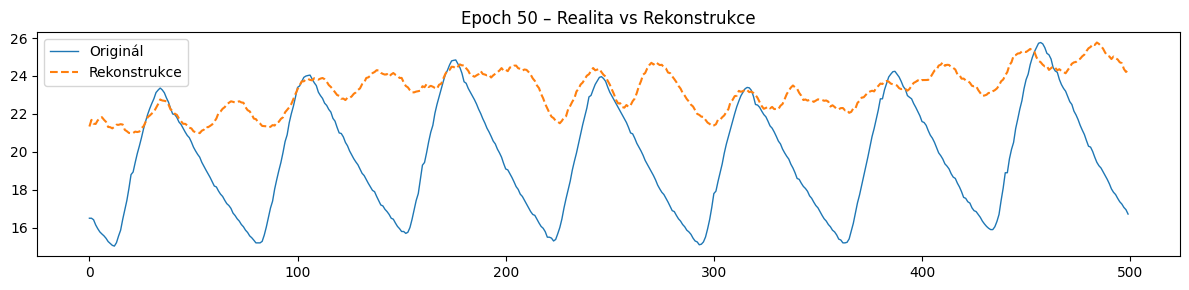

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


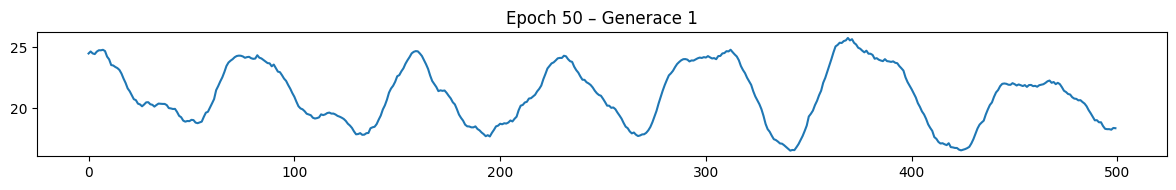

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


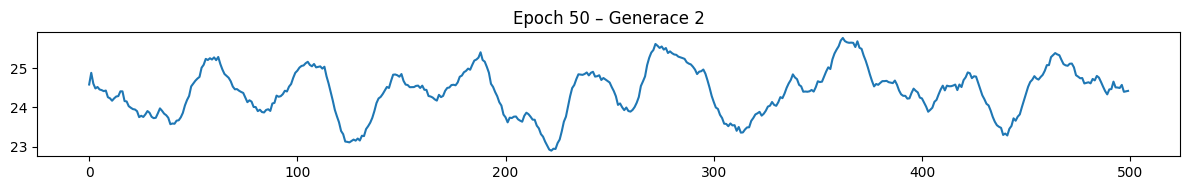

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


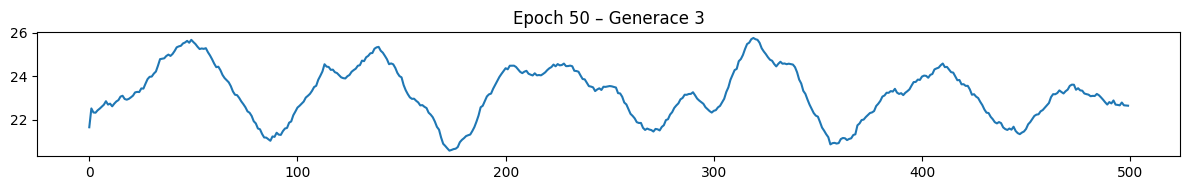


🔍 Epoch 60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


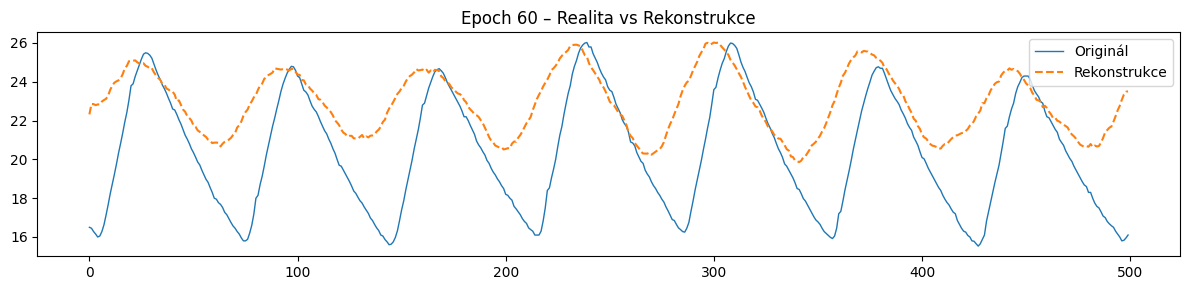

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


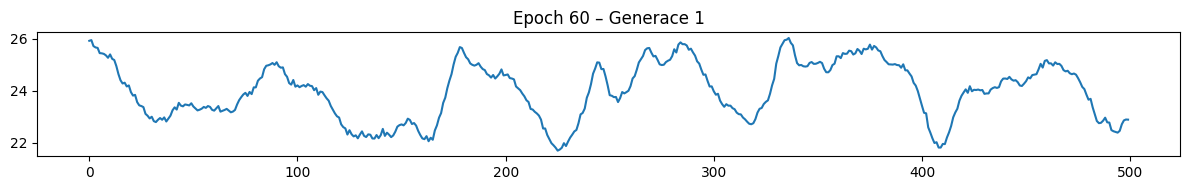

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


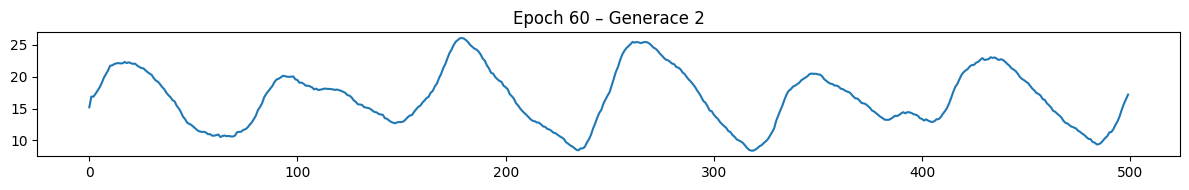

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


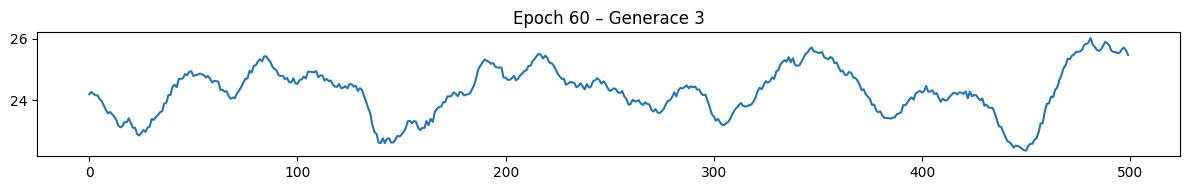


🔍 Epoch 70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


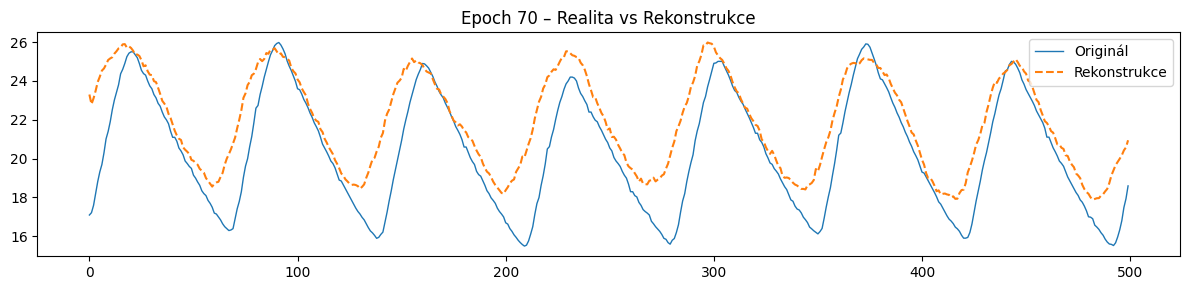

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


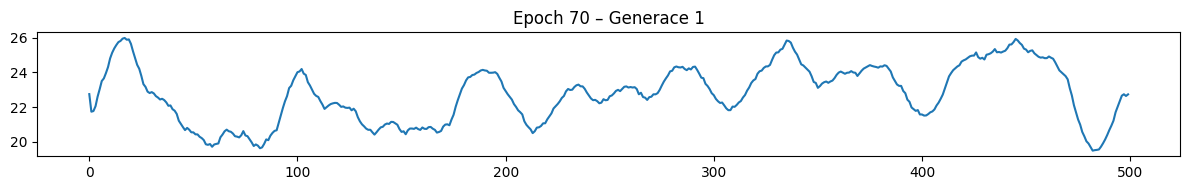

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


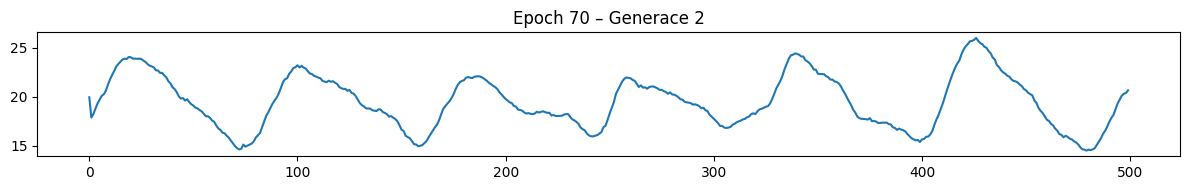

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


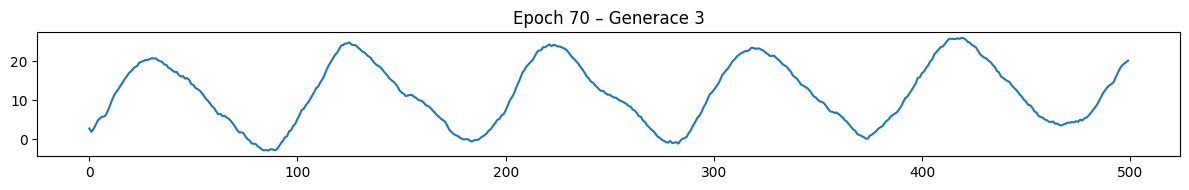


🔍 Epoch 80
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


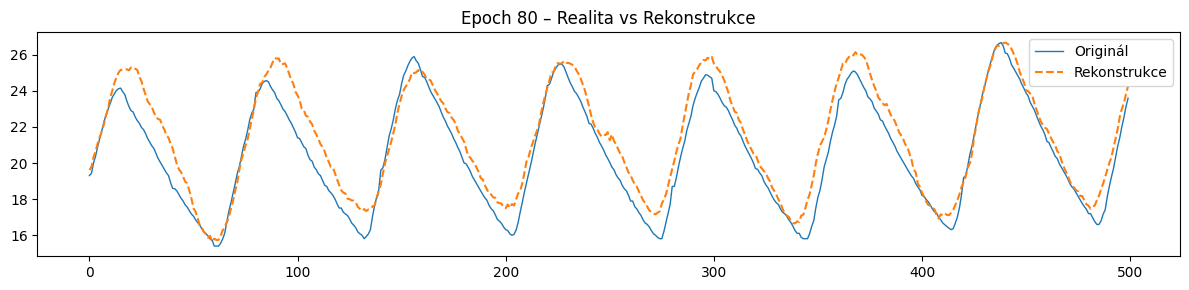

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


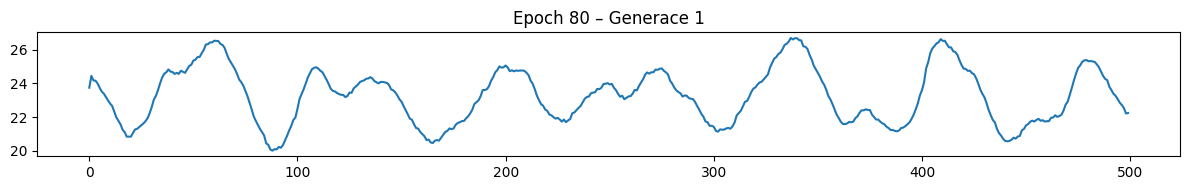

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


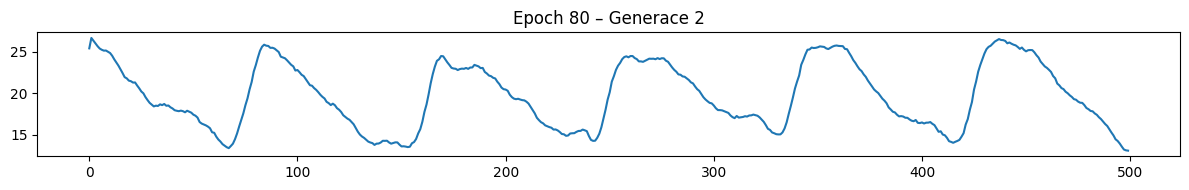

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


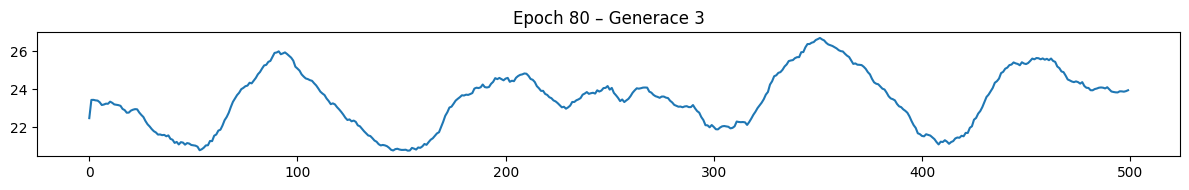


🔍 Epoch 90
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


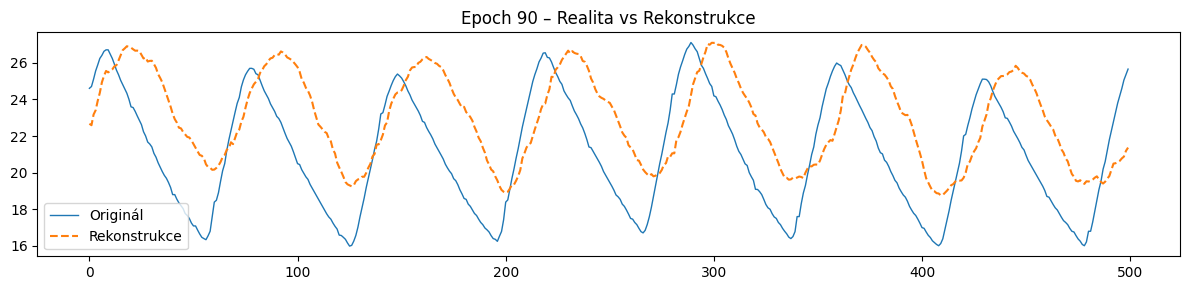

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


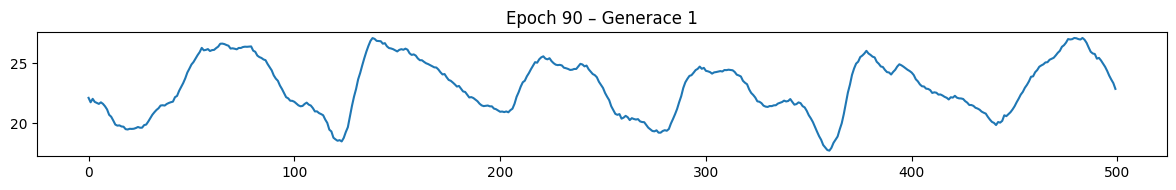

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


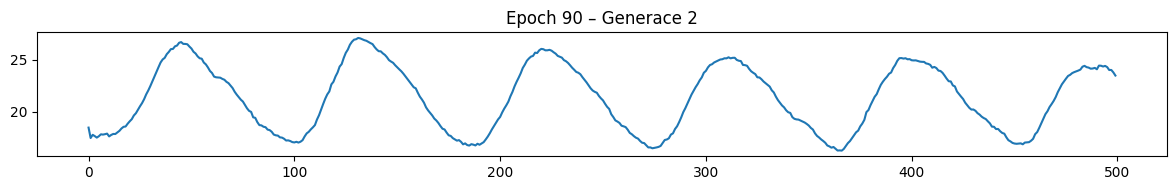

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


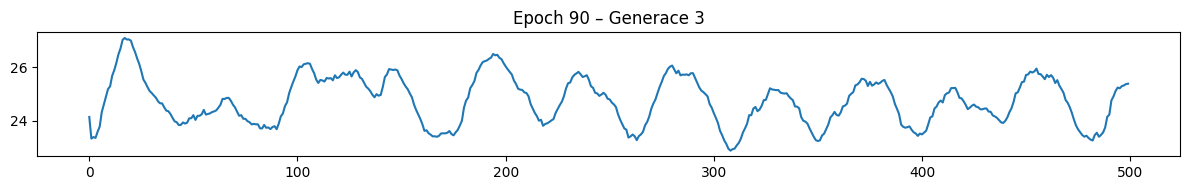


🔍 Epoch 100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


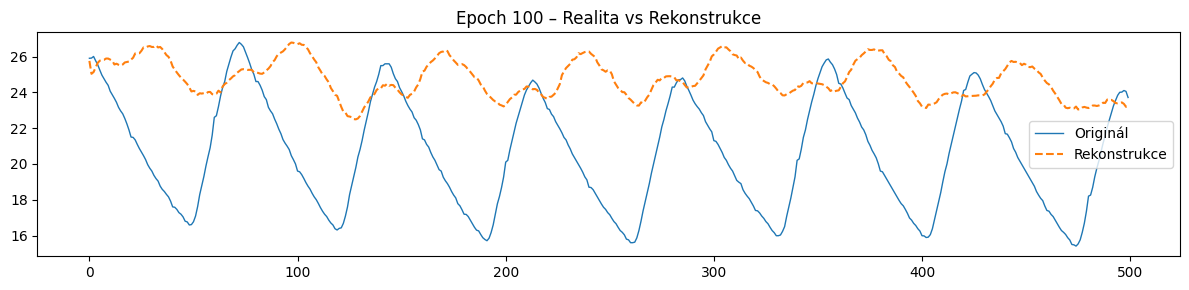

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


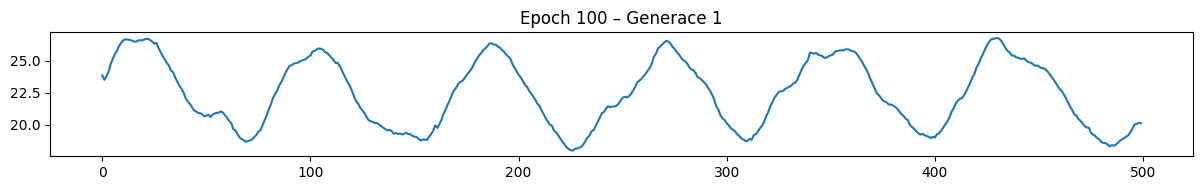

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


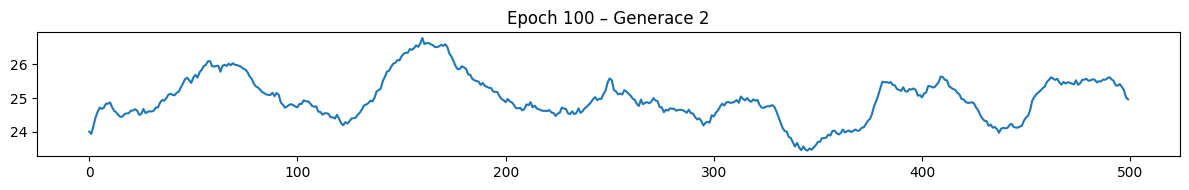

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


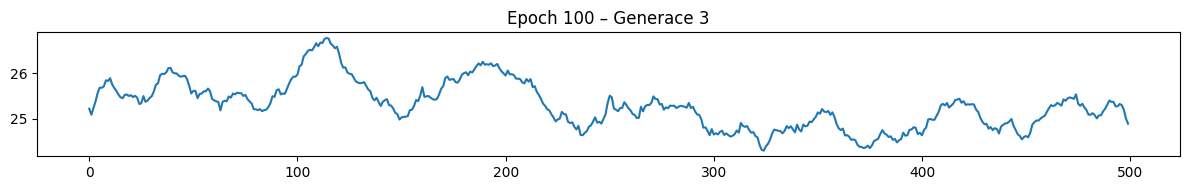

In [89]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.preprocessing import StandardScaler
import joblib
from lib.loader import FolderExtractor, SingleFileExtractor
from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras.models import load_model

# === PARAMETRY ===
HDF_PATH = "data"
SIGNAL_NAME = "icp"
WINDOW_SIZE = 500
N_COMPONENTS = WINDOW_SIZE // 2 + 1
LATENT_DIM = 48
EPOCHS = 100
BATCH_SIZE = 32
MAX_BETA = 1e-2
MIN_KL = 0.2
MODEL_DIR = "modelpokusicp"
SCALER_PATH = os.path.join(MODEL_DIR, "rfft_scaler.pkl")
os.makedirs(MODEL_DIR, exist_ok=True)

# === NAHRANI A FFT ===
def get_file_paths(folder_path):
    return [e._hdf5_file_path for e in FolderExtractor(folder_path)._extractors]

def load_signal(file_path, annotations_path, signal_name="art"):
    extractor = SingleFileExtractor(file_path)
    extractor.auto_annotate(annotations_path)
    segments, _ = extractor.extract(signal_name)
    extractor.load_data(segments)
    clean = [s.data for s in segments if not s.anomalous and s.data is not None]
    return np.concatenate(clean) if clean else np.array([])

def compute_rfft_spectra(signal, window_size):
    spectra, originals = [], []
    for i in range(0, len(signal) - window_size + 1, window_size):
        window = signal[i:i + window_size]
        if not np.isnan(window).any():
            fft_vals = np.fft.rfft(window)
            spectrum = np.stack([fft_vals.real, fft_vals.imag], axis=-1)
            spectra.append(spectrum)
            originals.append(window)
    return np.array(spectra), np.array(originals)

# === PŘÍPRAVA DAT ===
spectra_list, originals_list = [], []
for path in get_file_paths(HDF_PATH):
    signal = load_signal(path, HDF_PATH, SIGNAL_NAME)
    if signal.size == 0:
        continue
    spec, orig = compute_rfft_spectra(signal, WINDOW_SIZE)
    spectra_list.append(spec)
    originals_list.append(orig)

X = np.vstack(spectra_list)
originals = np.vstack(originals_list)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.reshape(-1, 2)).reshape(X.shape)
joblib.dump(scaler, SCALER_PATH)

@register_keras_serializable()
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def build_encoder(input_shape, latent_dim):
    inputs = layers.Input(shape=input_shape)
    x = layers.Flatten()(inputs)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(64, activation="relu")(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)
    z = Sampling()([z_mean, z_log_var])
    return Model(inputs, [z_mean, z_log_var, z], name="encoder")

def build_decoder(latent_dim, output_shape):
    inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(128, activation="relu")(inputs)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dense(np.prod(output_shape))(x)
    outputs = layers.Reshape(output_shape)(x)
    return Model(inputs, outputs, name="decoder")

class VAE(Model):
    def __init__(self, encoder, decoder, total_epochs, max_beta=1e-2, min_kl=0.2):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.total_epochs = total_epochs
        self.max_beta = max_beta
        self.min_kl = min_kl
        self.current_epoch = tf.Variable(0, trainable=False, dtype=tf.float32)
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer

    def train_step(self, data):
        if isinstance(data, tuple): data = data[0]
        progress = self.current_epoch / self.total_epochs
        beta = self.max_beta * tf.sigmoid((progress - 0.5) * 10.0)

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            recon = self.decoder(z)
            loss_recon = tf.reduce_mean(tf.square(data - recon))
            kl_per_dim = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_sum = tf.reduce_mean(tf.reduce_sum(tf.maximum(kl_per_dim, self.min_kl), axis=1))
            loss_total = loss_recon + beta * kl_sum

        grads = tape.gradient(loss_total, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(loss_total)
        self.recon_loss_tracker.update_state(loss_recon)
        self.kl_loss_tracker.update_state(kl_sum)
        self.current_epoch.assign_add(1.0 / tf.cast(self.total_epochs, tf.float32))

        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result()
        }

encoder = build_encoder((N_COMPONENTS, 2), LATENT_DIM)
decoder = build_decoder(LATENT_DIM, (N_COMPONENTS, 2))
vae = VAE(encoder, decoder, total_epochs=EPOCHS, max_beta=MAX_BETA, min_kl=MIN_KL)
vae.compile(optimizer=tf.keras.optimizers.Adam(1e-4))

for epoch in range(1, EPOCHS + 1):
    print(f"Epocha: {epoch}")
    vae.fit(X_scaled, epochs=1, batch_size=BATCH_SIZE, verbose=0)
    if epoch % 10 == 0 or epoch == EPOCHS:
        encoder.save(os.path.join(MODEL_DIR, f"vae_encoder_epoch{epoch:03d}.keras"))
        decoder.save(os.path.join(MODEL_DIR, f"vae_decoder_epoch{epoch:03d}.keras"))

# === TESTOVÁNÍ MODELŮ ===
model_files = sorted(os.listdir(MODEL_DIR))
encoders = [f for f in model_files if f.startswith("vae_encoder_epoch")]
decoders = [f for f in model_files if f.startswith("vae_decoder_epoch")]
model_pairs = []
for enc_file in encoders:
    epoch = enc_file.replace("vae_encoder_epoch", "").replace(".keras", "")
    dec_file = f"vae_decoder_epoch{epoch}.keras"
    if dec_file in decoders:
        model_pairs.append((
            os.path.join(MODEL_DIR, enc_file),
            os.path.join(MODEL_DIR, dec_file),
            int(epoch)
        ))

# === VIZUALIZACE ===
for idx, (encoder_path, decoder_path, epoch) in enumerate(model_pairs):
    print(f"\n🔍 Epoch {epoch}")
    encoder = load_model(encoder_path, compile=False, custom_objects={"Sampling": Sampling})
    decoder = load_model(decoder_path, compile=False)

    sample = X_scaled[idx % len(X_scaled)][None, ...]
    original = originals[idx % len(originals)]

    z_mean, z_log_var, z = encoder.predict(sample)
    recon = decoder.predict(z)
    recon = scaler.inverse_transform(recon.reshape(-1, 2)).reshape(recon.shape)[0]
    recon_spectrum = recon[:, 0] + 1j * recon[:, 1]
    recon_time = np.fft.irfft(recon_spectrum, n=WINDOW_SIZE)

    recon_time *= np.max(np.abs(original)) / (np.max(np.abs(recon_time)) + 1e-8)

    plt.figure(figsize=(12, 3))
    plt.plot(original, label="Originál", linewidth=1)
    plt.plot(recon_time, label="Rekonstrukce", linestyle="--")
    plt.title(f"Epoch {epoch} – Realita vs Rekonstrukce")
    plt.legend()
    plt.tight_layout()
    plt.show()

    for i in range(3):
        z_new = np.random.normal(size=z.shape)
        gen = decoder.predict(z_new)
        gen = scaler.inverse_transform(gen.reshape(-1, 2)).reshape(gen.shape)[0]
        gen_spectrum = gen[:, 0] + 1j * gen[:, 1]
        gen_time = np.fft.irfft(gen_spectrum, n=WINDOW_SIZE)
        gen_time *= np.max(np.abs(original)) / (np.max(np.abs(gen_time)) + 1e-8)

        plt.figure(figsize=(12, 2))
        plt.plot(gen_time)
        plt.title(f"Epoch {epoch} – Generace {i+1}")
        plt.tight_layout()
        plt.show()


In [ ]:
def generate_long_signal(decoder, scaler, segments=5):
    generated_segments = []
    for _ in range(segments):
        z_new = np.random.normal(size=(1, LATENT_DIM))
        gen = decoder.predict(z_new)
        gen = scaler.inverse_transform(gen.reshape(-1, 2)).reshape(gen.shape)[0]
        spectrum = gen[:, 0] + 1j * gen[:, 1]
        time_signal = np.fft.irfft(spectrum, n=WINDOW_SIZE)
        time_signal *= 100.0 / (np.max(np.abs(time_signal)) + 1e-8)  # škálování pro lepší amplitudu
        generated_segments.append(time_signal)
    return np.concatenate(generated_segments)

In [ ]:
decoder = load_model(os.path.join(MODEL_DIR, "vae_decoder_epoch060.keras"), compile=False)


for i in range(3):
    z_new = np.random.normal(size=z.shape)
    gen = decoder.predict(z_new)
    gen = scaler.inverse_transform(gen.reshape(-1, 2)).reshape(gen.shape)[0]
    gen_spectrum = gen[:, 0] + 1j * gen[:, 1]
    gen_time = np.fft.irfft(gen_spectrum, n=WINDOW_SIZE)
    gen_time *= np.max(np.abs(original)) / (np.max(np.abs(gen_time)) + 1e-8)

    plt.figure(figsize=(12, 2))
    plt.plot(gen_time)
    plt.title(f"Epoch {epoch} – Generace {i+1} num:{z_new}")
    plt.tight_layout()
    plt.show()


🔍 Epoch 10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


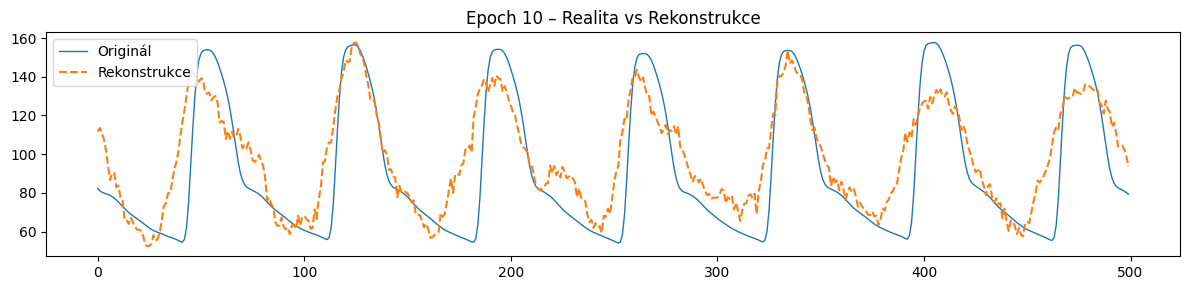

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


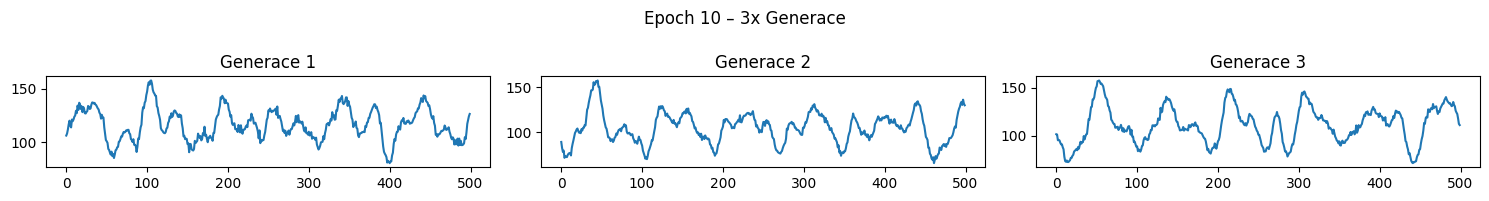


🔍 Epoch 20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


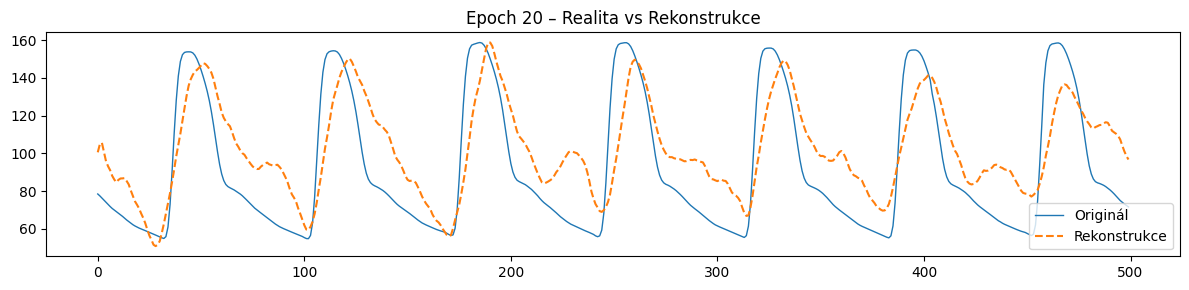

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


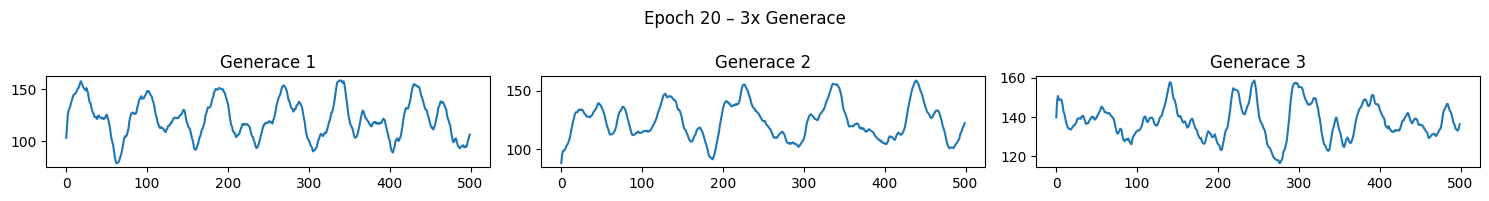


🔍 Epoch 30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


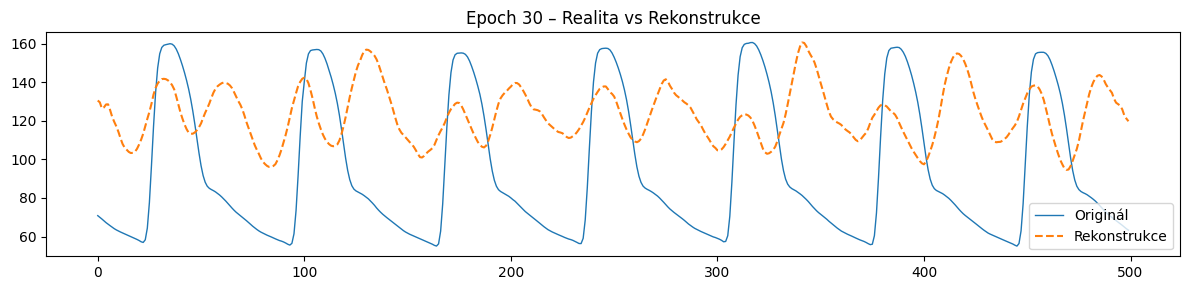

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


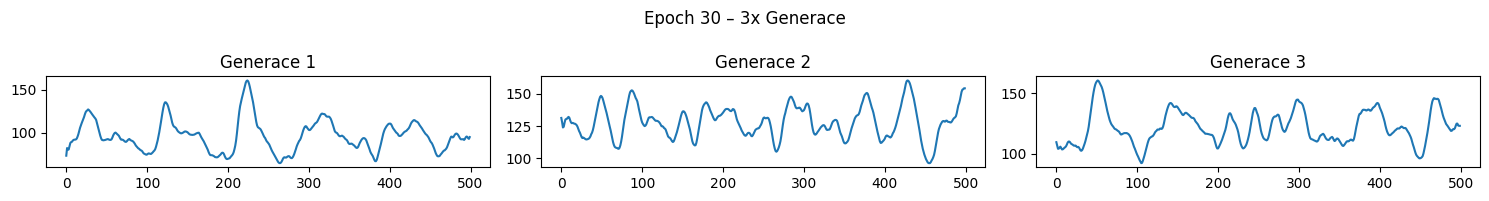


🔍 Epoch 40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


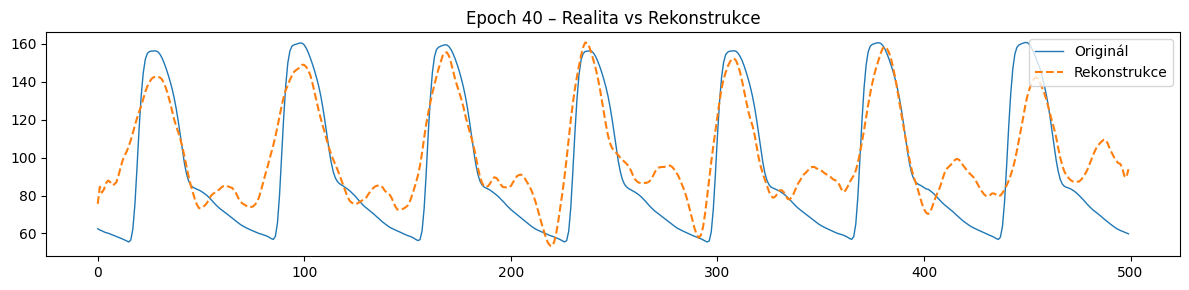

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


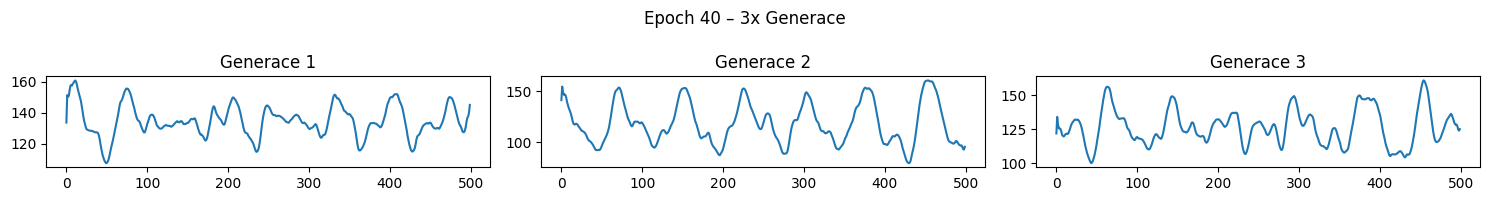


🔍 Epoch 50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


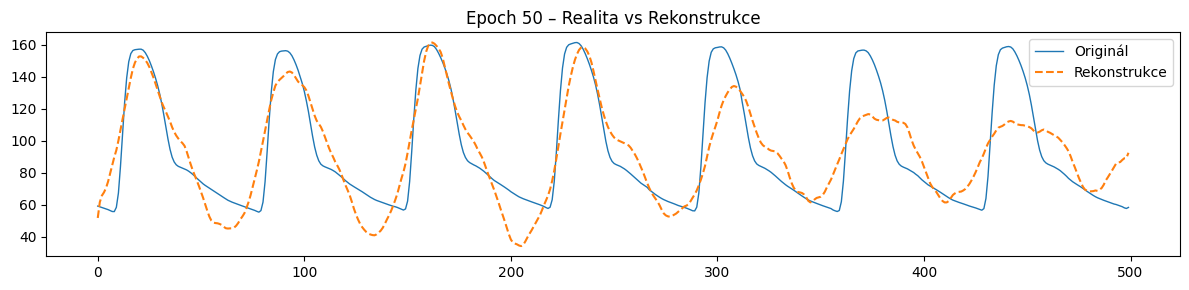

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


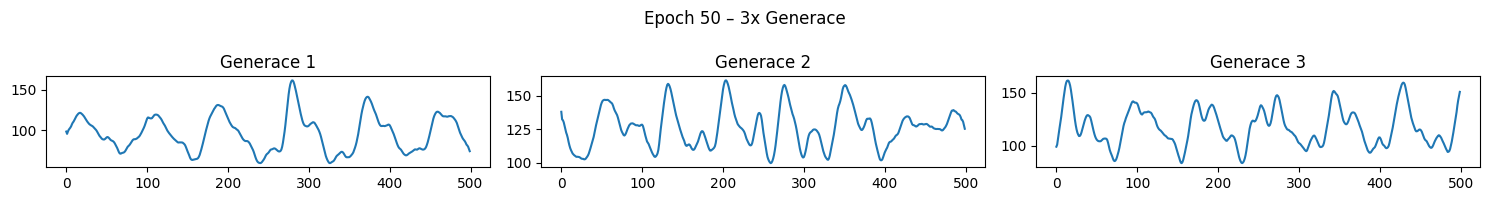


🔍 Epoch 60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


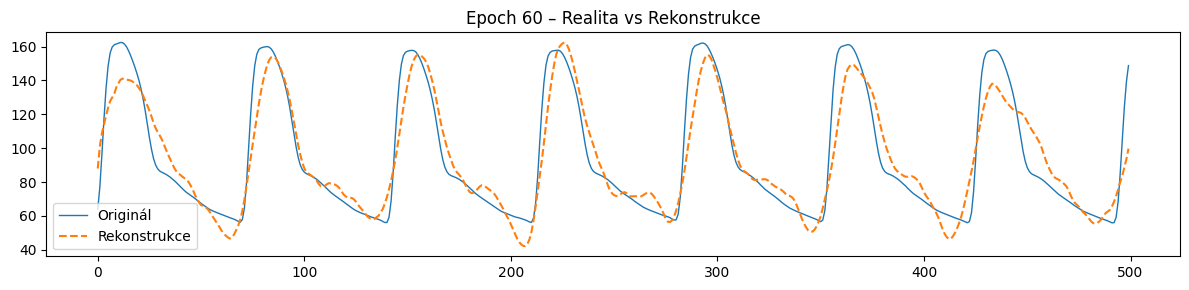

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


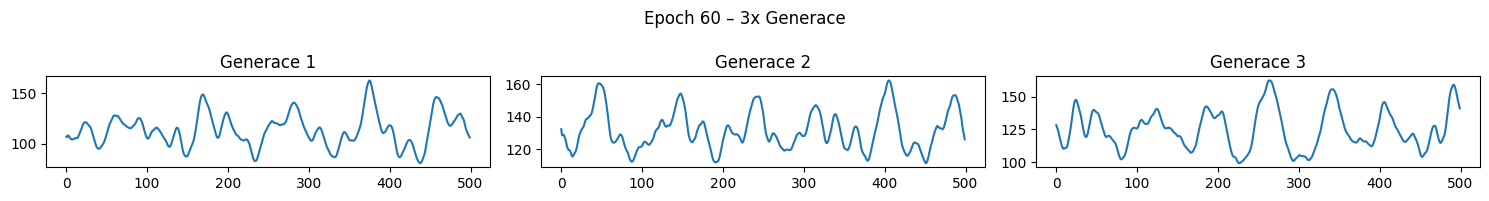


🔍 Epoch 70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


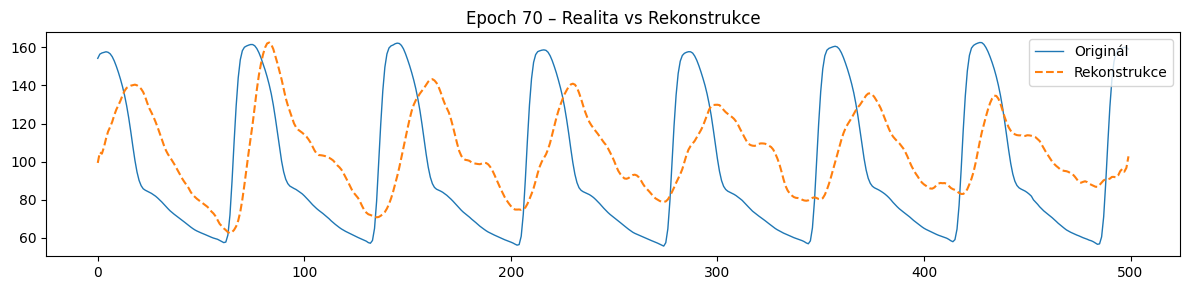

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


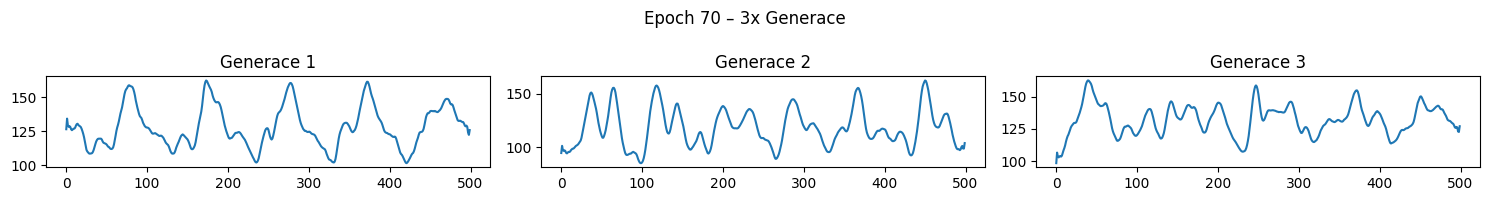


🔍 Epoch 80
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


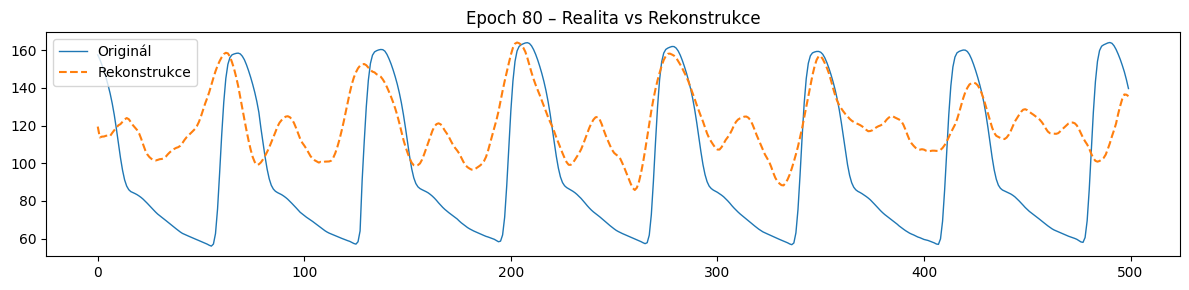

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


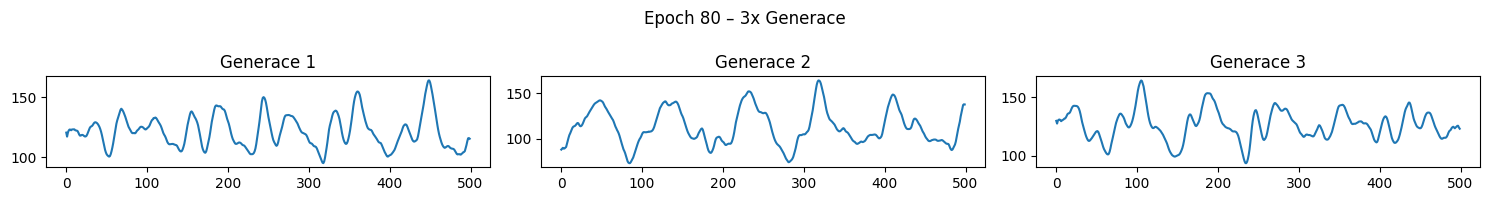


🔍 Epoch 90
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


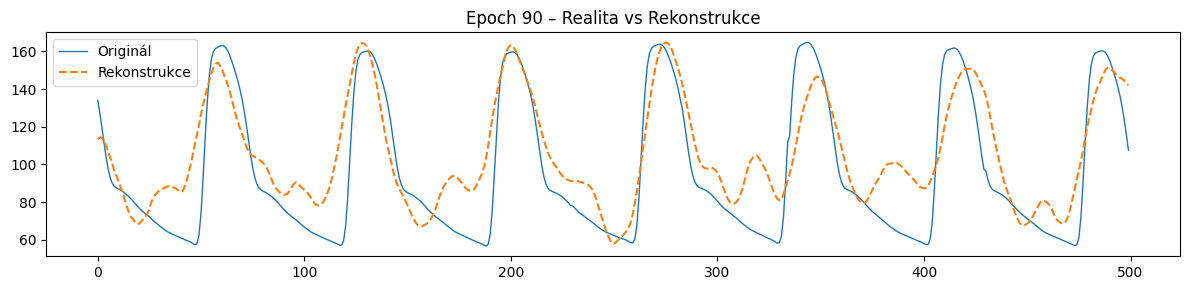

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


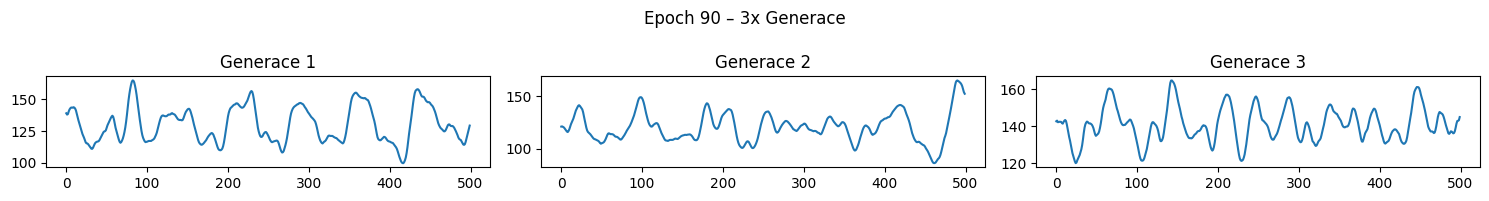


🔍 Epoch 100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


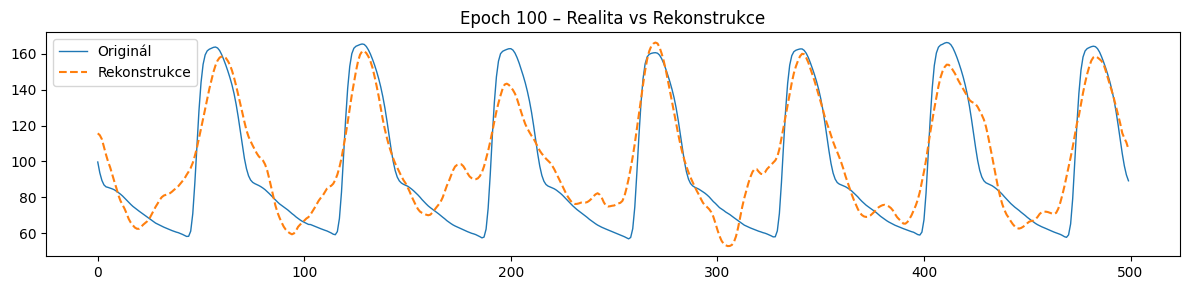

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


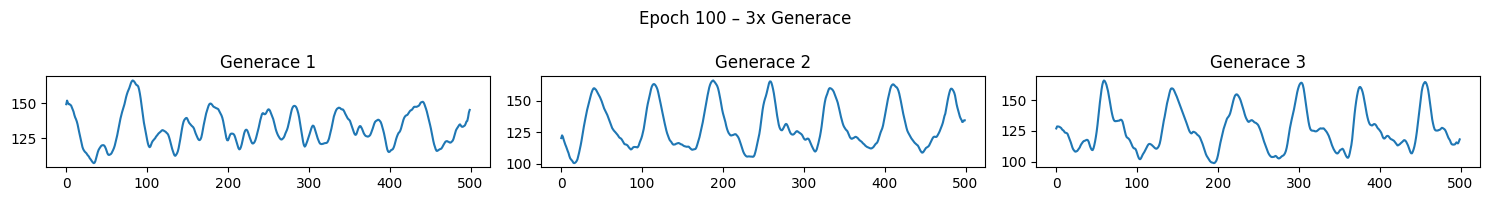

In [81]:
# === VIZUALIZACE ===
model_pairs = []
for enc_file in encoders:
    epoch = enc_file.replace("vae_encoder_epoch", "").replace(".keras", "")
    dec_file = f"vae_decoder_epoch{epoch}.keras"
    if dec_file in decoders:
        model_pairs.append((
            os.path.join(MODEL_DIR, enc_file),
            os.path.join(MODEL_DIR, dec_file),
            int(epoch)
        ))

for idx, (encoder_path, decoder_path, epoch) in enumerate(model_pairs):
    print(f"\n🔍 Epoch {epoch}")
    encoder = load_model(encoder_path, compile=False, custom_objects={"Sampling": Sampling})
    decoder = load_model(decoder_path, compile=False)

    sample = X_scaled[idx % len(X_scaled)][None, ...]
    original = originals[idx % len(originals)]

    z_mean, z_log_var, z = encoder.predict(sample)
    recon = decoder.predict(z)
    recon = scaler.inverse_transform(recon.reshape(-1, 2)).reshape(recon.shape)[0]
    recon_spectrum = recon[:, 0] + 1j * recon[:, 1]
    recon_time = np.fft.irfft(recon_spectrum, n=WINDOW_SIZE)
    recon_time *= np.max(np.abs(original)) / (np.max(np.abs(recon_time)) + 1e-8)

    plt.figure(figsize=(12, 3))
    plt.plot(original, label="Originál", linewidth=1)
    plt.plot(recon_time, label="Rekonstrukce", linestyle="--")
    plt.title(f"Epoch {epoch} – Realita vs Rekonstrukce")
    plt.legend()
    plt.tight_layout()
    plt.show()

    fig, axs = plt.subplots(1, 3, figsize=(15, 2))
    for i in range(3):
        z_new = np.random.normal(size=z.shape)
        gen = decoder.predict(z_new)
        gen = scaler.inverse_transform(gen.reshape(-1, 2)).reshape(gen.shape)[0]
        gen_spectrum = gen[:, 0] + 1j * gen[:, 1]
        gen_time = np.fft.irfft(gen_spectrum, n=WINDOW_SIZE)
        gen_time *= np.max(np.abs(original)) / (np.max(np.abs(gen_time)) + 1e-8)

        axs[i].plot(gen_time)
        axs[i].set_title(f"Generace {i+1}")

    fig.suptitle(f"Epoch {epoch} – 3x Generace")
    plt.tight_layout()
    plt.show()


In [ ]:

xhead = generate_long_signal(decoder, scaler, segments=600)

plt.figure(figsize=(12, 2))
plt.plot(xhead)
plt.title("Generovaný dlouhý signál")
plt.tight_layout()


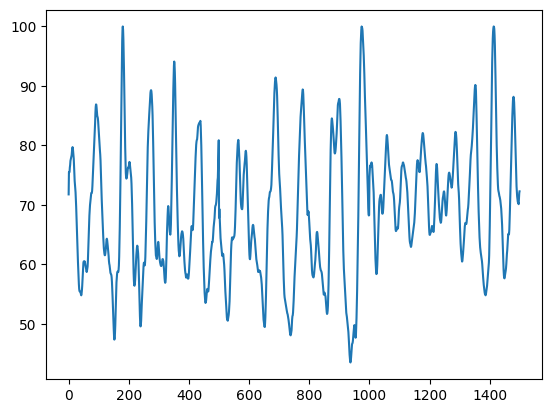

In [80]:
plt.plot(xhead[0:1500])

# Best

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


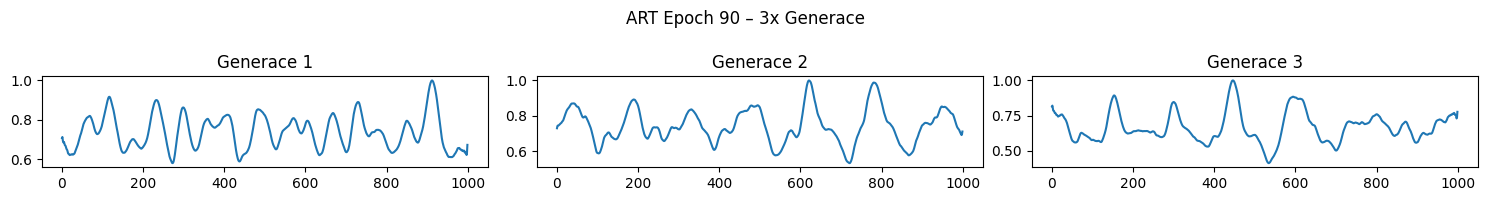

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


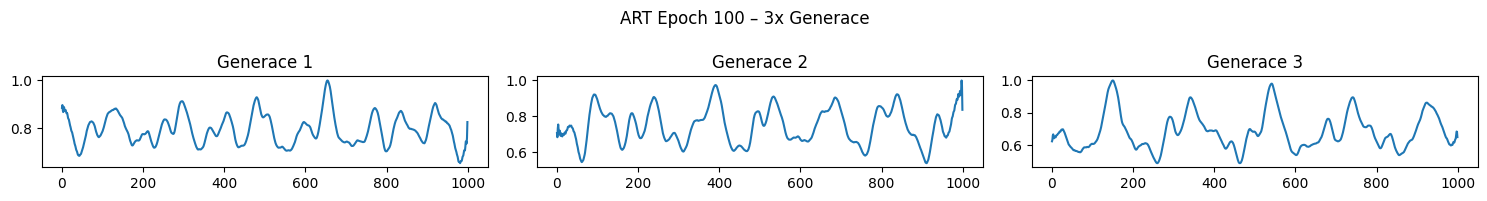

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


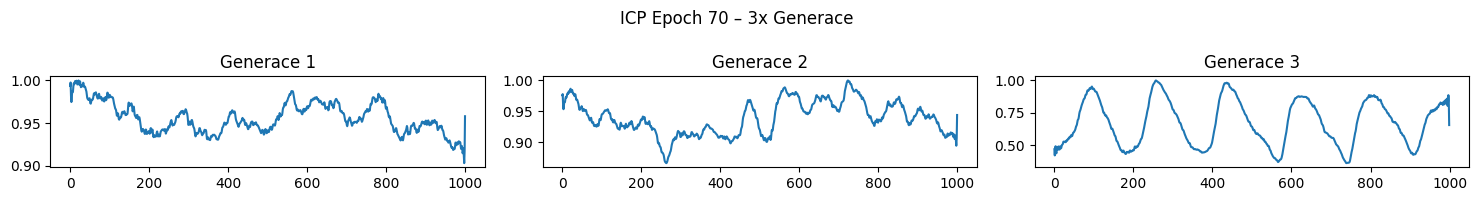

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


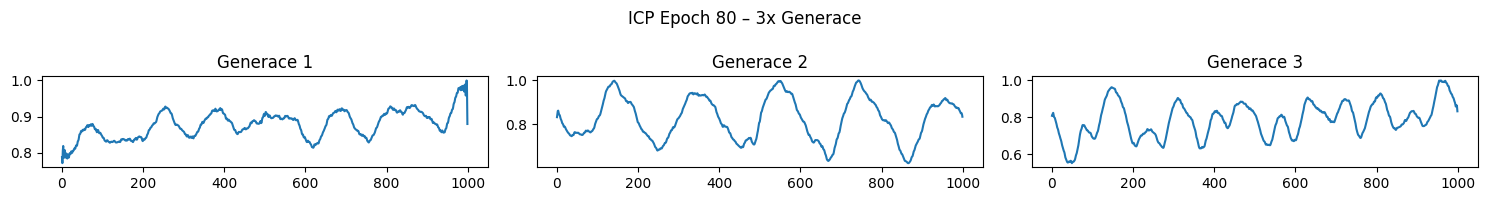

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


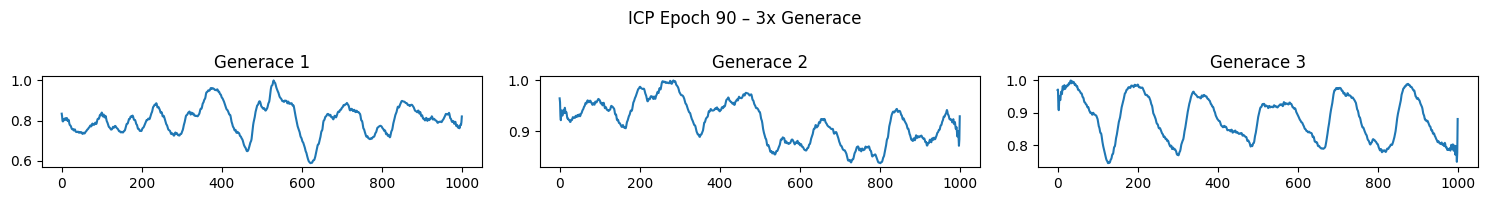

4034/4034 ━━━━━━━━━━━━━━━━━━━━ 4s 964us/step
4034/4034 ━━━━━━━━━━━━━━━━━━━━ 4s 898us/step

=== ART Epoch 90 ===
MSE:           1799697334272.000000
MAE:           5740.857422
KL Divergence: inf
Latent mean:   0.1119, std: 375.1824
   1/4034 ━━━━━━━━━━━━━━━━━━━━ 4:06 61ms/step

C:\Users\micha\AppData\Local\Temp\ipykernel_4696\2211910361.py:114: RuntimeWarning: overflow encountered in exp
  kl = -0.5 * np.mean(1 + z_log_var - np.square(z_mean) - np.exp(z_log_var))
c:\Development\Hackithon2025\Hackathon-2025\.venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


4034/4034 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step
4034/4034 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step


C:\Users\micha\AppData\Local\Temp\ipykernel_4696\2211910361.py:114: RuntimeWarning: overflow encountered in exp
  kl = -0.5 * np.mean(1 + z_log_var - np.square(z_mean) - np.exp(z_log_var))
c:\Development\Hackithon2025\Hackathon-2025\.venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)



=== ART Epoch 100 ===
MSE:           1800862171136.000000
MAE:           5830.440430
KL Divergence: inf
Latent mean:   0.0514, std: 380.5032
4034/4034 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step
4034/4034 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step


C:\Users\micha\AppData\Local\Temp\ipykernel_4696\2211910361.py:114: RuntimeWarning: overflow encountered in exp
  kl = -0.5 * np.mean(1 + z_log_var - np.square(z_mean) - np.exp(z_log_var))



=== ICP Epoch 70 ===
MSE:           124345368576.000000
MAE:           707.618225
KL Divergence: inf
Latent mean:   -0.1330, std: 425.4436
4034/4034 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step
4034/4034 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step


C:\Users\micha\AppData\Local\Temp\ipykernel_4696\2211910361.py:114: RuntimeWarning: overflow encountered in exp
  kl = -0.5 * np.mean(1 + z_log_var - np.square(z_mean) - np.exp(z_log_var))
c:\Development\Hackithon2025\Hackathon-2025\.venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)



=== ICP Epoch 80 ===
MSE:           134768533504.000000
MAE:           720.644531
KL Divergence: inf
Latent mean:   -0.0690, std: 442.1078
4034/4034 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step
4034/4034 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step

=== ICP Epoch 90 ===
MSE:           136418648064.000000
MAE:           737.425049
KL Divergence: inf
Latent mean:   -0.1309, std: 439.8098


C:\Users\micha\AppData\Local\Temp\ipykernel_4696\2211910361.py:114: RuntimeWarning: overflow encountered in exp
  kl = -0.5 * np.mean(1 + z_log_var - np.square(z_mean) - np.exp(z_log_var))


In [104]:
import os
import numpy as np
import matplotlib.pyplot as plt
import joblib
import h5py
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import load_model

# === KONSTANTY ===
MODEL_DIR = 'usablemodels/Vae500/'
SCALER_PATH_ART = os.path.join(MODEL_DIR, "rfft_scaler_art.pkl")
SCALER_PATH_ICP = os.path.join(MODEL_DIR, "rfft_scaler_icp.pkl")
FFT_DATA_PATH = "output/all_fft_signals.hdf5"
WINDOW_SIZE = 1000

# === NAČTENÍ SCALERŮ ===
scaler_art = joblib.load(SCALER_PATH_ART)
scaler_icp = joblib.load(SCALER_PATH_ICP)

# === NAČTENÍ FFT DAT ===
with h5py.File(FFT_DATA_PATH, "r") as f:
    re = f["fft/re"][:]
    im = f["fft/im"][:]
    fft_data = np.stack([re, im], axis=-1)

# === BEZPEČNÉ NAČTENÍ MODELŮ ===
def safe_load(path):
    try:
        return load_model(path, compile=False)
    except Exception as e:
        print(f"⚠️ Nelze načíst {os.path.basename(path)}: {e}")
        return None

# === ART MODELY ===
decoder90 = safe_load(os.path.join(MODEL_DIR, "vae_decoder_epoch090art.keras"))
decoder100 = safe_load(os.path.join(MODEL_DIR, "vae_decoder_epoch100art.keras"))
encoder90 = safe_load(os.path.join(MODEL_DIR, "vae_encoder_epoch090art.keras"))
encoder100 = safe_load(os.path.join(MODEL_DIR, "vae_encoder_epoch100art.keras"))

# === ICP MODELY ===
encoder70icp = safe_load(os.path.join(MODEL_DIR, "vae_encoder_epoch070icp.keras"))
encoder80icp = safe_load(os.path.join(MODEL_DIR, "vae_encoder_epoch080icp.keras"))
encoder90icp = safe_load(os.path.join(MODEL_DIR, "vae_encoder_epoch090icp.keras"))
decoder70icp = safe_load(os.path.join(MODEL_DIR, "vae_decoder_epoch070icp.keras"))
decoder80icp = safe_load(os.path.join(MODEL_DIR, "vae_decoder_epoch080icp.keras"))
decoder90icp = safe_load(os.path.join(MODEL_DIR, "vae_decoder_epoch090icp.keras"))

# === GENERACE SIGNÁLU Z LATENTNÍHO PROSTORU ===
for decoder, scaler, label in [
    (decoder90, scaler_art, "ART Epoch 90"),
    (decoder100, scaler_art, "ART Epoch 100"),
    (decoder70icp, scaler_icp, "ICP Epoch 70"),
    (decoder80icp, scaler_icp, "ICP Epoch 80"),
    (decoder90icp, scaler_icp, "ICP Epoch 90")
]:
    if decoder is None:
        continue

    latent_dim = decoder.input_shape[1]
    fig, axs = plt.subplots(1, 3, figsize=(15, 2))
    for i in range(3):
        z = np.random.normal(size=(latent_dim,))
        gen = decoder.predict(z[np.newaxis])[0]  # (N, 2)
        gen_scaled = scaler.inverse_transform(gen)
        spectrum = gen_scaled[:, 0] + 1j * gen_scaled[:, 1]
        signal = np.fft.irfft(spectrum, n=WINDOW_SIZE)
        signal /= (np.max(np.abs(signal)) + 1e-8)
        axs[i].plot(signal)
        axs[i].set_title(f"Generace {i+1}")
    fig.suptitle(f"{label} – 3x Generace")
    plt.tight_layout()
    plt.show()

# === METRIKY ===
def evaluate_model(name, encoder, decoder, scaler):
    if encoder is None or decoder is None:
        print(f"⛔ Přeskočeno: {name}")
        return

    input_shape = encoder.input_shape
    if len(input_shape) != 3 or input_shape[-1] != 2:
        print(f"❌ Neznámý vstupní tvar encoderu {name}: {input_shape}")
        return

    frame_len = input_shape[1]
    total_len = fft_data.shape[0]
    num_samples = total_len // frame_len
    reshaped_fft = fft_data[:num_samples * frame_len].reshape((num_samples, frame_len, 2))

    z_mean, z_log_var, _ = encoder.predict(reshaped_fft)
    reconstructed = decoder.predict(z_mean)

    try:
        recon_scaled = scaler.inverse_transform(reconstructed.reshape(-1, 2)).reshape(reconstructed.shape)
    except ValueError as e:
        print(f"❌ Chyba při inverse_transform: {e}")
        return

    true_data = reshaped_fft.reshape(-1, 2)
    recon_flat = recon_scaled.reshape(-1, 2)

    # === FILTRACE NaN ===
    mask = ~np.isnan(true_data).any(axis=1) & ~np.isnan(recon_flat).any(axis=1)
    true_data_clean = true_data[mask]
    recon_clean = recon_flat[mask]

    if len(true_data_clean) == 0:
        print(f"⚠️ Všechna data obsahují NaN — {name} přeskočeno")
        return

    mse = mean_squared_error(true_data_clean, recon_clean)
    mae = mean_absolute_error(true_data_clean, recon_clean)
    kl = -0.5 * np.mean(1 + z_log_var - np.square(z_mean) - np.exp(z_log_var))

    print(f"\n=== {name} ===")
    print(f"MSE:           {mse:.6f}")
    print(f"MAE:           {mae:.6f}")
    print(f"KL Divergence: {kl:.6f}")
    print(f"Latent mean:   {np.mean(z_mean):.4f}, std: {np.std(z_mean):.4f}")

# === EVALUACE ART ===
evaluate_model("ART Epoch 90", encoder90, decoder90, scaler_art)
evaluate_model("ART Epoch 100", encoder100, decoder100, scaler_art)

# === EVALUACE ICP ===
evaluate_model("ICP Epoch 70", encoder70icp, decoder70icp, scaler_icp)
evaluate_model("ICP Epoch 80", encoder80icp, decoder80icp, scaler_icp)
evaluate_model("ICP Epoch 90", encoder90icp, decoder90icp, scaler_icp)


In [103]:
x90 = generate_long_signal(decoder90, scaler, segments=5)
plt.figure(figsize=(12, 2))
plt.plot(x90)
x100 = generate_long_signal(decoder100, scaler, segments=5)
plt.figure(figsize=(12, 2))
plt.plot(x100)
plt.show()

InvalidArgumentError: Graph execution error:

Detected at node decoder_1/dense_95_1/Relu defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "c:\Development\Hackithon2025\Hackathon-2025\.venv\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "c:\Development\Hackithon2025\Hackathon-2025\.venv\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "c:\Development\Hackithon2025\Hackathon-2025\.venv\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "c:\Development\Hackithon2025\Hackathon-2025\.venv\Lib\site-packages\tornado\platform\asyncio.py", line 211, in start

  File "C:\Program Files\Python311\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Program Files\Python311\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Program Files\Python311\Lib\asyncio\events.py", line 80, in _run

  File "c:\Development\Hackithon2025\Hackathon-2025\.venv\Lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "c:\Development\Hackithon2025\Hackathon-2025\.venv\Lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "c:\Development\Hackithon2025\Hackathon-2025\.venv\Lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "c:\Development\Hackithon2025\Hackathon-2025\.venv\Lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "c:\Development\Hackithon2025\Hackathon-2025\.venv\Lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "c:\Development\Hackithon2025\Hackathon-2025\.venv\Lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "c:\Development\Hackithon2025\Hackathon-2025\.venv\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "c:\Development\Hackithon2025\Hackathon-2025\.venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3098, in run_cell

  File "c:\Development\Hackithon2025\Hackathon-2025\.venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3153, in _run_cell

  File "c:\Development\Hackithon2025\Hackathon-2025\.venv\Lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner

  File "c:\Development\Hackithon2025\Hackathon-2025\.venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3365, in run_cell_async

  File "c:\Development\Hackithon2025\Hackathon-2025\.venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3610, in run_ast_nodes

  File "c:\Development\Hackithon2025\Hackathon-2025\.venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3670, in run_code

  File "C:\Users\micha\AppData\Local\Temp\ipykernel_4696\2563397616.py", line 1, in <module>

  File "C:\Users\micha\AppData\Local\Temp\ipykernel_4696\1872938511.py", line 5, in generate_long_signal

  File "c:\Development\Hackithon2025\Hackathon-2025\.venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Development\Hackithon2025\Hackathon-2025\.venv\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 566, in predict

  File "c:\Development\Hackithon2025\Hackathon-2025\.venv\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 260, in one_step_on_data_distributed

  File "c:\Development\Hackithon2025\Hackathon-2025\.venv\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 250, in one_step_on_data

  File "c:\Development\Hackithon2025\Hackathon-2025\.venv\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 105, in predict_step

  File "c:\Development\Hackithon2025\Hackathon-2025\.venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Development\Hackithon2025\Hackathon-2025\.venv\Lib\site-packages\keras\src\layers\layer.py", line 936, in __call__

  File "c:\Development\Hackithon2025\Hackathon-2025\.venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Development\Hackithon2025\Hackathon-2025\.venv\Lib\site-packages\keras\src\ops\operation.py", line 58, in __call__

  File "c:\Development\Hackithon2025\Hackathon-2025\.venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Development\Hackithon2025\Hackathon-2025\.venv\Lib\site-packages\keras\src\models\functional.py", line 183, in call

  File "c:\Development\Hackithon2025\Hackathon-2025\.venv\Lib\site-packages\keras\src\ops\function.py", line 177, in _run_through_graph

  File "c:\Development\Hackithon2025\Hackathon-2025\.venv\Lib\site-packages\keras\src\models\functional.py", line 648, in call

  File "c:\Development\Hackithon2025\Hackathon-2025\.venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Development\Hackithon2025\Hackathon-2025\.venv\Lib\site-packages\keras\src\layers\layer.py", line 936, in __call__

  File "c:\Development\Hackithon2025\Hackathon-2025\.venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Development\Hackithon2025\Hackathon-2025\.venv\Lib\site-packages\keras\src\ops\operation.py", line 58, in __call__

  File "c:\Development\Hackithon2025\Hackathon-2025\.venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Development\Hackithon2025\Hackathon-2025\.venv\Lib\site-packages\keras\src\layers\core\dense.py", line 155, in call

  File "c:\Development\Hackithon2025\Hackathon-2025\.venv\Lib\site-packages\keras\src\activations\activations.py", line 47, in relu

  File "c:\Development\Hackithon2025\Hackathon-2025\.venv\Lib\site-packages\keras\src\activations\activations.py", line 101, in static_call

  File "c:\Development\Hackithon2025\Hackathon-2025\.venv\Lib\site-packages\keras\src\backend\tensorflow\nn.py", line 15, in relu

Matrix size-incompatible: In[0]: [1,4], In[1]: [48,128]
	 [[{{node decoder_1/dense_95_1/Relu}}]] [Op:__inference_one_step_on_data_distributed_7322662]